In [1]:
#!pip install keras-tuner
#!pip install --upgrade tensorflow

import os
import pandas as pd
import geopandas as gpd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
np.bool = np.bool_
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from kerastuner import HyperModel, RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import seaborn as sns
from shapely.geometry import Point
import re
import tensorflow as tf
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam
import pyogrio

#!pip install gluonts
#!pip install mxnet
#!pip install --upgrade mxnet == 1.6
#!pip install "gluonts[torch]"

# Import DeepAR packages
#from gluonts.dataset.pandas import PandasDataset
#from gluonts.dataset.split import split
#from gluonts.mx import DeepAREstimator, Trainer

/var/folders/gv/9rdl5b851912bg6vpps84lh40000gn/T/ipykernel_19338/1843480389.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


## Read trips dataset and external data

In [2]:
# List of files
files = [
    'Chicago_Weather.csv',
    'Weekly_Gas_Prices_Abridged.csv',
    'Weekly_Gas_Prices.csv', # We should be able to remove since _Abridged contains our timeframe
    'E_Scooter_Trips.csv',
    'Chicago_Crimes.csv',
    'Race_and_Ethnicity',
    # 'Citizenship.csv',
    'Education.csv',
    #'Housing.csv',
    'Poverty.csv',
    'Income.csv'
]

# Function to read a file and print its columns
def print_column_names(file_path):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        print(f"File format not supported for {file_path}")
        return
    print(f"Columns in {os.path.basename(file_path)}: {df.columns.tolist()}")

# Iterate over the files, read each one, and print column names
for file in files:
    file_path = os.path.join(file)
    print_column_names(file_path)

Columns in Chicago_Weather.csv: ['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations']
Columns in Weekly_Gas_Prices_Abridged.csv: ['Date', 'Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)']
Columns in Weekly_Gas_Prices.csv: ['Date', 'Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)']
Columns in E_Scooter_Trips.csv: ['Trip ID', 'Start Time', 'End Time', 'Trip Distance', 'Trip Duration', 'Vendor', 'Start Community Area Number', 'End Community Area Number', 'Start Community Area Name', 'End Community Area Name', 'Start Centroid Latitude', 'Start Centroid Longitude'

In [3]:
# Trips data
df_e_scooter_trips = pd.read_csv('E_Scooter_Trips.csv')

# Weather data
df_weather = pd.read_csv('Chicago_Weather.csv')

# Crime data
df_crimes = pd.read_csv('Chicago_Crimes.csv')

# Gas data
df_gas = pd.read_csv('Weekly_Gas_Prices_Abridged.csv')

# Race and Ethnicity
df_race = pd.read_csv('Race_and_Ethnicity.csv')

# Citizenship
# df_citizenship = pd.read_csv('Citizenship.csv')

# Education
df_education = pd.read_csv('Education.csv')

# Housing
#df_housing = pd.read_csv('Housing.csv')

# Poverty
df_poverty = pd.read_csv('Poverty.csv')

# Income
df_income = pd.read_csv('Income.csv')

print(f'Trips Dataset: {df_e_scooter_trips.shape}\nWeather Data: {df_weather.shape}' +
'\nCrime Data: {df_crimes.shape}\nGas Data: {df_gas.shape}' +
'\nRace Data: {df_race.shape}\nIncome Data: {df_income.shape}')

Trips Dataset: (3797237, 16)
Weather Data: (514, 33)
Crime Data: {df_crimes.shape}
Gas Data: {df_gas.shape}
Race Data: {df_race.shape}
Income Data: {df_income.shape}


In [4]:
# Function to quickly inspect the datasets
def inspect_data(df, name):
    print(f"--- Inspecting {name} ---")
    print("First few rows:")
    print(df.head())
    print("\nSummary Statistics:")
#     print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print(df.info())
    print("\n")

In [5]:
# Inspect each dataset
inspect_data(df_weather, "Weather Data")
inspect_data(df_gas, "Gas Prices Data")
inspect_data(df_e_scooter_trips, "E-Scooter Trips Data")
inspect_data(df_crimes, "Crimes Data")
inspect_data(df_race, "Community Areas Race Data")
# inspect_data(df_citizenship, "Citizenship Status Data")
inspect_data(df_education, "Education Level Data")
#inspect_data(df_housing, "Housing Occupancy Data")
inspect_data(df_poverty, "Poverty Data")
#inspect_data(df_insurance, "Insurance Data")
inspect_data(df_income, "Community Areas Income Data")

--- Inspecting Weather Data ---
First few rows:
                    name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Chicago,United States  2022-05-05     52.9     44.3  49.7          52.9   
1  Chicago,United States  2022-05-06     52.7     49.7  51.1          52.7   
2  Chicago,United States  2022-05-07     64.5     47.6  55.9          64.5   
3  Chicago,United States  2022-05-08     66.9     45.7  58.3          66.9   
4  Chicago,United States  2022-05-09     83.5     57.1  70.8          83.3   

   feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0          40.5       48.8  42.7      76.8  ...          3.5        1   
1          45.1       50.9  45.2      81.4  ...          2.1        1   
2          43.9       55.5  31.4      40.6  ...         19.0        9   
3          43.8       57.8  38.8      48.8  ...          8.5        4   
4          57.1       70.8  50.8      49.6  ...         13.9        7   

   severerisk              sunrise          

Trip ID                           0
Start Time                        0
End Time                          0
Trip Distance                     0
Trip Duration                     0
Vendor                            0
Start Community Area Number    2827
End Community Area Number      3941
Start Community Area Name      2827
End Community Area Name        3941
Start Centroid Latitude        2827
Start Centroid Longitude       2827
Start Centroid Location        2827
End Centroid Latitude          3941
End Centroid Longitude         3941
End Centroid Location          3941
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797237 entries, 0 to 3797236
Data columns (total 16 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Trip ID                      object 
 1   Start Time                   object 
 2   End Time                     object 
 3   Trip Distance                int64  
 4   Trip Duration                int64  
 5  

# Data Cleaning (External Datasets)

### Aggregate data for 3 hours

In [6]:
# Convert 'Start Time' and 'End Time' to datetime in one line
df_e_scooter_trips[['Start Time', 'End Time']] = pd.to_datetime(df_e_scooter_trips[['Start Time', 'End Time']].stack()).unstack()


/var/folders/gv/9rdl5b851912bg6vpps84lh40000gn/T/ipykernel_19338/2935311629.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_e_scooter_trips[['Start Time', 'End Time']] = pd.to_datetime(df_e_scooter_trips[['Start Time', 'End Time']].stack()).unstack()


In [7]:
# Floor to the nearest 3-hour interval
df_e_scooter_trips['trip_start'] = df_e_scooter_trips['Start Time'].dt.floor('1H')
df_e_scooter_trips['trip_end'] = df_e_scooter_trips['End Time'].dt.floor('1H')

In [8]:
start_demand = df_e_scooter_trips.groupby(['trip_start', 'Start Community Area Number']).size().reset_index(name='trip_count')

In [9]:
start_demand

,trip_start,Start Community Area Number,trip_count
0,2022-05-10 09:00:00,32.0,4
1,2022-05-10 10:00:00,28.0,1
2,2022-05-10 10:00:00,32.0,9
3,2022-05-10 11:00:00,7.0,1
4,2022-05-10 11:00:00,8.0,5
...,...,...,...
401151,2023-09-30 20:00:00,57.0,1
401152,2023-09-30 20:00:00,63.0,1
401153,2023-09-30 20:00:00,66.0,2
401154,2023-09-30 20:00:00,72.0,3


In [10]:
end_demand = df_e_scooter_trips.groupby(['trip_end', 'End Community Area Number']).size().reset_index(name='trip_count')

In [11]:
end_demand

,trip_end,End Community Area Number,trip_count
0,2022-05-10 09:00:00,32.0,3
1,2022-05-10 10:00:00,28.0,1
2,2022-05-10 10:00:00,32.0,9
3,2022-05-10 11:00:00,7.0,1
4,2022-05-10 11:00:00,8.0,6
...,...,...,...
408030,2023-09-30 21:00:00,66.0,1
408031,2023-09-30 21:00:00,69.0,2
408032,2023-09-30 21:00:00,70.0,2
408033,2023-09-30 21:00:00,72.0,1


In [12]:
# Save DataFrame to CSV
#end_demand.to_csv('end_demand.csv', index=False)

## Public Transit Dataset

In [13]:

# Public Bus Transit data
df_bus = pd.read_csv('cta-bus-stops-2.csv')
# Public Rails Transit data
df_rails = pd.read_csv('cta-rail-stops.csv')

# Geospatial file for Chicago community areas
geo_communities = 'community_areas_chicago.geojson'

# Load the community areas data
geo_community_areas = gpd.read_file(geo_communities)

In [14]:
geo_community_areas.shape

(77, 10)

### Match bus stop coordinates to the corresponding community areas

In [15]:
# We only take the ones in service (status 1)
df_bus = df_bus[df_bus['STATUS'] == 1]

In [16]:
def string_to_point(point_str):
    # Extract coordinates using regex
    coords = re.findall(r"[-\d\.]+", point_str)
    # Convert strings to float and create Point geometry
    return Point(float(coords[0]), float(coords[1]))

In [17]:
# List of all the coordinate locations of the bus stops
list_of_points = df_bus['the_geom'].tolist()
points = []

# Convert to Point datatype
for p in list_of_points:
    points.append(string_to_point(p))

In [18]:
gdf_points = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
points_in_community = gpd.sjoin(gdf_points, geo_community_areas, how="inner", op='within')

/Users/roopeshraveendran/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [19]:
points_in_community = points_in_community[['geometry', 'community', 'area_numbe']]
points_in_community.head()

,geometry,community,area_numbe
0,POINT (-87.54863 41.72818),SOUTH CHICAGO,46
62,POINT (-87.56119 41.75174),SOUTH CHICAGO,46
114,POINT (-87.54823 41.75223),SOUTH CHICAGO,46
262,POINT (-87.54699 41.73003),SOUTH CHICAGO,46
272,POINT (-87.55430 41.73729),SOUTH CHICAGO,46


In [20]:
# Assuming points_in_community is a Series, convert it to a DataFrame and inspect
points_in_community_df = points_in_community.reset_index()

# Rename the columns appropriately
points_in_community_df.columns = ['index', 'geometry', 'community', 'area_number']

In [21]:
# Drop rows with NaN values in the 'Start Community Area Number' column
start_demand = start_demand.dropna(subset=['Start Community Area Number'])

# Convert the community area numbers to integers
start_demand['Start Community Area Number'] = start_demand['Start Community Area Number'].astype(int)
points_in_community_df['area_number'] = points_in_community_df['area_number'].astype(int)

In [22]:
# Count the number of trips for each community area number
bus_stops = points_in_community_df['area_number'].value_counts().reset_index()
bus_stops.columns = ['area_number', 'bus_stops']

In [23]:
# Ensure the columns used for merging are of the same type
bus_stops['area_number'] = bus_stops['area_number'].astype(int)
start_demand['Start Community Area Number'] = start_demand['Start Community Area Number'].astype(int)

# Merge bus_stops with df_trips on 'Start Community Area Number'
merged_df = pd.merge(start_demand, bus_stops, left_on='Start Community Area Number', right_on='area_number', how='left')

# Drop unnecessary columns if any
start_demand = merged_df.drop(columns=['area_number'])

start_demand['bus_stops'] = start_demand['bus_stops'].fillna(0)
start_demand.head()

,trip_start,Start Community Area Number,trip_count,bus_stops
0,2022-05-10 09:00:00,32,4,154
1,2022-05-10 10:00:00,28,1,366
2,2022-05-10 10:00:00,32,9,154
3,2022-05-10 11:00:00,7,1,175
4,2022-05-10 11:00:00,8,5,268


### Match bus stop coordinates to the corresponding community areas

In [24]:
# Function to convert location strings to Point objects
def string_to_point_rails(point_str):
    # Extract coordinates using regex
    coords = re.findall(r"[-\d\.]+", point_str)
    if len(coords) == 2:
        # Convert strings to float and create Point geometry
        return Point(float(coords[1]), float(coords[0]))
    return None

In [25]:
# List of all the coordinate locations of the bus stops
list_of_points = df_rails['Location'].tolist()
points = []

# Convert to Point datatype
for p in list_of_points:
    points.append(string_to_point_rails(p))

In [26]:
gdf_points = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

In [27]:
points_in_community = gpd.sjoin(gdf_points, geo_community_areas, how="inner", op='within')
points_in_community = points_in_community[['geometry', 'community', 'area_numbe']]
points_in_community.head()

/Users/roopeshraveendran/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,geometry,community,area_numbe
1,POINT (-87.71484 41.85384),NORTH LAWNDALE,29
50,POINT (-87.70541 41.85396),NORTH LAWNDALE,29
124,POINT (-87.72431 41.85373),NORTH LAWNDALE,29
163,POINT (-87.73326 41.85375),NORTH LAWNDALE,29
172,POINT (-87.72431 41.85373),NORTH LAWNDALE,29


In [28]:
# Assuming points_in_community is a Series, convert it to a DataFrame and inspect
points_in_community_df = points_in_community.reset_index()

# Rename the columns appropriately
points_in_community_df.columns = ['index', 'geometry', 'community', 'area_number']

In [29]:
# Convert the community area numbers to integers
start_demand['Start Community Area Number'] = start_demand['Start Community Area Number'].astype(int)
points_in_community_df['area_number'] = points_in_community_df['area_number'].astype(int)

In [30]:
# Count the number of trips for each community area number
train_stops = points_in_community_df['area_number'].value_counts().reset_index()
train_stops.columns = ['area_number', 'train_stops']

In [31]:
# Ensure the columns used for merging are of the same type
train_stops['area_number'] = train_stops['area_number'].astype(int)
start_demand['Start Community Area Number'] = start_demand['Start Community Area Number'].astype(int)

# Merge bus_stops with df_trips on 'Start Community Area Number'
merged_df = pd.merge(start_demand, train_stops, left_on='Start Community Area Number', right_on='area_number', how='left')

# Drop unnecessary columns if any
start_demand = merged_df.drop(columns=['area_number'])
start_demand['train_stops'] = start_demand['train_stops'].fillna(0)

In [32]:
start_demand.head()

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops
0,2022-05-10 09:00:00,32,4,154,34.0
1,2022-05-10 10:00:00,28,1,366,18.0
2,2022-05-10 10:00:00,32,9,154,34.0
3,2022-05-10 11:00:00,7,1,175,6.0
4,2022-05-10 11:00:00,8,5,268,14.0


## Crimes Dataset

In [33]:
# Handling missing values in the Crimes dataset
# Fill missing coordinates and location with NaN
df_crimes[['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location']] = df_crimes[['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location']].replace(0, np.nan)

# For 'Location Description', 'District', 'Ward', and 'Community Area', we will fill missing values with a placeholder
df_crimes['Location Description'] = df_crimes['Location Description'].fillna('Unknown')
df_crimes['District'] = df_crimes['District'].fillna('Unknown')
df_crimes['Ward'] = df_crimes['Ward'].fillna('Unknown')
df_crimes['Community Area'] = df_crimes['Community Area'].fillna('Unknown')

# Dropping rows where essential coordinates are missing since they are crucial for spatial analysis
df_crimes.dropna(subset=['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude'], inplace=True)

In [34]:
df_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,36.0,19.0,01A,1141387.0,1913179.0,2021,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
2,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,...,50.0,13.0,01A,1152781.0,1941458.0,2021,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
3,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,47.0,5.0,05,1162518.0,1925906.0,2023,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
4,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,...,6.0,44.0,08B,1183071.0,1847869.0,2023,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"
6,13203321,JG415333,09/06/2023 05:00:00 PM,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"


In [35]:
df_crimes['Primary Type'].value_counts()

Primary Type
THEFT                                1677967
BATTERY                              1460382
CRIMINAL DAMAGE                       911869
NARCOTICS                             740588
ASSAULT                               527394
OTHER OFFENSE                         495156
BURGLARY                              429773
MOTOR VEHICLE THEFT                   398428
DECEPTIVE PRACTICE                    342801
ROBBERY                               301587
CRIMINAL TRESPASS                     217807
WEAPONS VIOLATION                     114104
PROSTITUTION                           69353
OFFENSE INVOLVING CHILDREN             53608
PUBLIC PEACE VIOLATION                 52928
SEX OFFENSE                            30191
CRIM SEXUAL ASSAULT                    26028
INTERFERENCE WITH PUBLIC OFFICER       18900
LIQUOR LAW VIOLATION                   14951
GAMBLING                               14536
ARSON                                  13667
HOMICIDE                               131

In [36]:
# List of relevant crime types
relevant_crimes = [
    'THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT', 'ROBBERY',
    'MOTOR VEHICLE THEFT', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION',
    'PUBLIC PEACE VIOLATION', 'SEX OFFENSE', 'CRIM SEXUAL ASSAULT',
    'HOMICIDE'
]

# Filter the DataFrame to only include the relevant crime types
filtered_df_crimes = df_crimes[df_crimes['Primary Type'].isin(relevant_crimes)]

In [37]:
filtered_df_crimes['Primary Type'].value_counts()

Primary Type
THEFT                     1677967
BATTERY                   1460382
CRIMINAL DAMAGE            911869
ASSAULT                    527394
MOTOR VEHICLE THEFT        398428
ROBBERY                    301587
CRIMINAL TRESPASS          217807
WEAPONS VIOLATION          114104
PUBLIC PEACE VIOLATION      52928
SEX OFFENSE                 30191
CRIM SEXUAL ASSAULT         26028
HOMICIDE                    13110
Name: count, dtype: int64

In [38]:
filtered_df_crimes['Community Area'].value_counts()

Community Area
Unknown    432440
25.0       287754
8.0        201312
28.0       176406
43.0       175474
            ...  
74.0        11546
12.0         9257
47.0         7779
9.0          5138
0.0            47
Name: count, Length: 79, dtype: int64

In [39]:
# First and last date
first_date = filtered_df_crimes['Date'].min()
last_date = filtered_df_crimes['Date'].max()

print(f'First date: {first_date}')
print(f'Last date: {last_date}')

First date: 01/01/2001 01:00:00 AM
Last date: 12/31/2023 12:55:00 AM


In [40]:
# Stack the Date column, convert to datetime, and unstack
filtered_df_crimes['Date'] = pd.to_datetime(filtered_df_crimes[['Date']].stack()).unstack()

# Filter the DataFrame to only include rows after 2021-01-01
filtered_df_crimes = filtered_df_crimes[filtered_df_crimes['Date'] > pd.Timestamp('2021-01-01')]


/var/folders/gv/9rdl5b851912bg6vpps84lh40000gn/T/ipykernel_19338/429230252.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df_crimes['Date'] = pd.to_datetime(filtered_df_crimes[['Date']].stack()).unstack()
/var/folders/gv/9rdl5b851912bg6vpps84lh40000gn/T/ipykernel_19338/429230252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_crimes['Date'] = pd.to_datetime(filtered_df_crimes[['Date']].stack()).unstack()


In [41]:
# First date and last date of filtered_df_crimes
first_date = filtered_df_crimes['Date'].min()
last_date = filtered_df_crimes['Date'].max()

print(f'First date: {first_date}')
print(f'Last date: {last_date}')

First date: 2021-01-01 00:01:00
Last date: 2024-04-11 00:00:00


### Merge crime with main dataset

In [42]:
# Extract the date part and create a new column 'Trip Date'
start_demand['Trip Date'] = start_demand['trip_start'].dt.date

# Create a new column 'Crime Date' in filtered_df_crimes
filtered_df_crimes['Crime Date'] = filtered_df_crimes['Date'].dt.date

# Group the filtered_df_crimes by 'Crime Date' and 'Community Area' and count the number of crimes
crime_counts = filtered_df_crimes.groupby(['Crime Date', 'Community Area']).size().reset_index(name='total_crimes')

# Merge the crime counts with escooter_df on 'Trip Date' and 'Start Community Area Number'
merged_df = pd.merge(start_demand, crime_counts,
                     left_on=['Trip Date', 'Start Community Area Number'],
                     right_on=['Crime Date', 'Community Area'],
                     how='left')

# Fill NaN values in 'total_crimes' with 0
merged_df['total_crimes'] = merged_df['total_crimes'].fillna(0)

# Drop the 'Crime Date' and 'Community Area' columns as they are no longer needed
start_demand = merged_df.drop(columns=['Crime Date', 'Community Area'])

## Race Dataset


In [43]:
# Cleaning the Race dataset
# Rename columns for clarity -- [TAB] dataset changed, this is no longer necessary. Commented out for now.
#df_race.rename(columns={'Race and Ethnicity in Chicago Community Areas': 'Community Area', 'Unnamed: 1': 'Data'}, inplace=True)
#df_race

In [44]:
columns_to_convert = ['total_population','asian', 'black', 'hispanic', 'white', 'other']

# Convert specified columns to numeric types
df_race[columns_to_convert] = df_race[columns_to_convert].replace({',': ''}, regex=True).apply(pd.to_numeric)

#Finding the percentage of race
df_race['asian_population_percentage'] = (df_race['asian'] / df_race['total_population']) * 100
df_race['black_population_percentage'] = (df_race['black'] / df_race['total_population']) * 100
df_race['hispanic_population_percentage'] = (df_race['hispanic'] / df_race['total_population']) * 100
df_race['white_population_percentage'] = (df_race['white'] / df_race['total_population']) * 100
df_race['other_population_percentage'] = (df_race['other'] / df_race['total_population']) * 100

# Merging with e-scooter trips
df_race_merge = df_race[['community_area_number', 'total_population', 'asian_population_percentage', 'black_population_percentage', 'hispanic_population_percentage',
                   'white_population_percentage', 'other_population_percentage']]

start_demand = pd.merge(start_demand, df_race_merge, left_on = 'Start Community Area Number', right_on = 'community_area_number')
start_demand.drop('community_area_number', axis=1, inplace=True)
start_demand.head()

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,hispanic_population_percentage,white_population_percentage,other_population_percentage
0,2022-05-10 09:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816
1,2022-05-10 10:00:00,32,9,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816
2,2022-05-10 11:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816
3,2022-05-10 12:00:00,32,3,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816
4,2022-05-10 13:00:00,32,8,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816


## Weather Dataset

In [45]:
df_weather.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [46]:
# Include cleaning up of weather dataset here
df_weather = df_weather[['datetime', 'temp', 'precip', 'snow']]
df_weather.head()

,datetime,temp,precip,snow
0,2022-05-05,49.7,0.188,0.0
1,2022-05-06,51.1,0.367,0.0
2,2022-05-07,55.9,0.000,0.0
3,2022-05-08,58.3,0.000,0.0
4,2022-05-09,70.8,0.000,0.0


In [47]:
# Convert 'datetime' in df_weather to datetime
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

# Extract the date part and create a new column 'Weather Date'
df_weather['Weather Date'] = df_weather['datetime'].dt.date

# Merge the weather data with merged_df on 'Trip Date'
final_merged_df = pd.merge(start_demand, df_weather,
                           left_on='Trip Date',
                           right_on='Weather Date',
                           how='left')

# Drop the 'Weather Date' column as it is no longer needed
start_demand = final_merged_df.drop(columns=['Weather Date'])

In [48]:
start_demand.head()

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,hispanic_population_percentage,white_population_percentage,other_population_percentage,datetime,temp,precip,snow
0,2022-05-10 09:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0
1,2022-05-10 10:00:00,32,9,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0
2,2022-05-10 11:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0
3,2022-05-10 12:00:00,32,3,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0
4,2022-05-10 13:00:00,32,8,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0


## Gas Dataset

In [49]:
# Include cleaning up of gas dataset here
df_gas.head()

,Date,"Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices (Dollars per Gallon)"
0,5/2/2022,4.467
1,5/9/2022,4.672
2,5/16/2022,4.929
3,5/23/2022,5.133
4,5/30/2022,5.264


In [50]:
# Convert 'Trip Date' in df_e_scooter_trips to datetime
start_demand['Trip Date'] = pd.to_datetime(start_demand['Trip Date'])

# Convert 'Date' in df_gas to datetime
df_gas['Date'] = pd.to_datetime(df_gas['Date'])

# Rename the gas price column for easier access
df_gas = df_gas.rename(columns={'Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)': 'Gas Price'})

# Create a new column 'Trip Week Start' representing the start of the week for each trip date
start_demand['Trip Week Start'] = start_demand['Trip Date'] - pd.to_timedelta(start_demand['Trip Date'].dt.weekday, unit='D')

# Merge the gas prices with df_e_scooter_trips on 'Trip Week Start'
final_merged_df = pd.merge(start_demand, df_gas,
                           left_on='Trip Week Start',
                           right_on='Date',
                           how='left')

# Drop the 'Date' and 'Trip Week Start' columns as they are no longer needed
start_demand = final_merged_df.drop(columns=['Date', 'Trip Week Start'])

In [51]:
#df_e_scooter_trips = df_e_scooter_trips.rename(columns={'Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)': 'Gas Price'})
start_demand.head()

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,hispanic_population_percentage,white_population_percentage,other_population_percentage,datetime,temp,precip,snow,Gas Price
0,2022-05-10 09:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0,4.672
1,2022-05-10 10:00:00,32,9,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0,4.672
2,2022-05-10 11:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0,4.672
3,2022-05-10 12:00:00,32,3,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0,4.672
4,2022-05-10 13:00:00,32,8,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,9.563404,58.977293,3.30816,2022-05-10,80.3,0.0,0.0,4.672


## Income Dataset

- We define low income as earning below 40,000.
- We define high income as earning above 130,000.

In [52]:
# Include cleaning up of income dataset here
df_income

,community_area_number,community_name,total_population,median_household_income,low_income,middle_income,high_income,below_10_income,10_to_15_income,15_to_20_income,...,35_to_40_income_percent,40_to_45_income_percent,45_to_50_income_percent,50_to_60_income_percent,60_to_75_income_percent,75_to_100_income_percent,100_to_125_income_percent,125_to_150_income_percent,150_to_200_income_percent,above_200_income_percent
0,1,Rogers Park,24916,46164,10925,11113,2878,2652,1836,1097,...,0.055025,0.053058,0.034034,0.078584,0.084524,0.123936,0.071882,0.041018,0.040616,0.033874
1,2,West Ridge,25869,57621,8498,12503,4868,1447,1039,1200,...,0.044880,0.050833,0.043836,0.096795,0.096641,0.116781,0.078434,0.056322,0.063358,0.068499
2,3,Uptown,30970,57576,11102,13694,6174,3200,1838,1286,...,0.037359,0.036067,0.038683,0.084759,0.090701,0.118728,0.073232,0.060510,0.070520,0.068324
3,4,Lincoln Square,18481,79696,4218,8901,5362,768,329,417,...,0.034847,0.040799,0.045560,0.061090,0.092636,0.134246,0.107299,0.092365,0.079866,0.117905
4,5,North Center,14237,132628,1926,4837,7474,323,215,163,...,0.032521,0.011730,0.010114,0.033153,0.058510,0.119969,0.106272,0.073119,0.136124,0.315727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Washington Heights,9331,53182,3784,4464,1083,1005,647,422,...,0.039331,0.033115,0.031079,0.084557,0.106419,0.098918,0.124317,0.039546,0.059908,0.016611
73,74,Mount Greenwood,6945,97101,1099,3243,2603,272,172,115,...,0.020878,0.040029,0.029230,0.058603,0.066811,0.161555,0.110727,0.109575,0.152628,0.112599
74,75,Morgan Park,8020,63517,2732,3607,1681,684,197,298,...,0.038404,0.050623,0.030424,0.048130,0.108728,0.104489,0.107357,0.066708,0.076185,0.066708
75,76,O'Hare,6460,60532,2073,3608,779,241,302,276,...,0.019814,0.035604,0.032817,0.105728,0.111455,0.183901,0.089009,0.043344,0.051393,0.025851


In [53]:
#Merging with e-scooter trips data
df_income_merge = df_income[['community_area_number', 'median_household_income',
                       'low_income_percent', 'middle_income_percent', 'high_income_percent']]
start_demand = pd.merge(start_demand, df_income_merge, left_on = 'Start Community Area Number', right_on = 'community_area_number')
start_demand.drop('community_area_number', axis=1, inplace=True)
start_demand.head()

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,...,other_population_percentage,datetime,temp,precip,snow,Gas Price,median_household_income,low_income_percent,middle_income_percent,high_income_percent
0,2022-05-10 09:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,3.30816,2022-05-10,80.3,0.0,0.0,4.672,112045,0.132542,0.430534,0.436925
1,2022-05-10 10:00:00,32,9,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,3.30816,2022-05-10,80.3,0.0,0.0,4.672,112045,0.132542,0.430534,0.436925
2,2022-05-10 11:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,3.30816,2022-05-10,80.3,0.0,0.0,4.672,112045,0.132542,0.430534,0.436925
3,2022-05-10 12:00:00,32,3,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,3.30816,2022-05-10,80.3,0.0,0.0,4.672,112045,0.132542,0.430534,0.436925
4,2022-05-10 13:00:00,32,8,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,3.30816,2022-05-10,80.3,0.0,0.0,4.672,112045,0.132542,0.430534,0.436925


## Education

In [54]:
df_education = df_education[['community_area_number', 'not_hs_grad_percent', 'hs_grad_percent', 'some_college_percent',
       'has_bachelors_percent', 'hs_grad_or_higher_percent']]
# Perform the merge
start_demand = pd.merge(start_demand, df_education, left_on='Start Community Area Number', right_on='community_area_number')
start_demand.drop('community_area_number', axis=1, inplace=True)
start_demand.head()

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,...,Gas Price,median_household_income,low_income_percent,middle_income_percent,high_income_percent,not_hs_grad_percent,hs_grad_percent,some_college_percent,has_bachelors_percent,hs_grad_or_higher_percent
0,2022-05-10 09:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,4.672,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96
1,2022-05-10 10:00:00,32,9,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,4.672,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96
2,2022-05-10 11:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,4.672,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96
3,2022-05-10 12:00:00,32,3,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,4.672,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96
4,2022-05-10 13:00:00,32,8,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,4.672,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96


## Poverty

In [55]:
df_poverty = df_poverty[['community_area_number', 'below_poverty_percent']]
# Perform the merge
start_demand = pd.merge(start_demand, df_poverty, left_on='Start Community Area Number', right_on='community_area_number')
start_demand.drop('community_area_number', axis=1, inplace=True)
start_demand.head()

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,...,median_household_income,low_income_percent,middle_income_percent,high_income_percent,not_hs_grad_percent,hs_grad_percent,some_college_percent,has_bachelors_percent,hs_grad_or_higher_percent,below_poverty_percent
0,2022-05-10 09:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96,0.093567
1,2022-05-10 10:00:00,32,9,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96,0.093567
2,2022-05-10 11:00:00,32,4,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96,0.093567
3,2022-05-10 12:00:00,32,3,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96,0.093567
4,2022-05-10 13:00:00,32,8,154,34.0,2022-05-10,7.0,39327,21.072037,7.079106,...,112045,0.132542,0.430534,0.436925,0.039708,0.032986,0.103038,0.824268,0.96,0.093567


## Combining Weather, Crime, Gas Price dataset with End Demand dataset ##

### Weather Data ###

In [56]:
# Extract the date part from trip_end and create a new column 'Trip End Date'
end_demand['Trip End Date'] = end_demand['trip_end'].dt.date

In [57]:
# Merge the weather data with merged_df on 'Trip Date'
weather_merged_end_df = pd.merge(end_demand, df_weather,
                           left_on ='Trip End Date',
                           right_on='Weather Date',
                           how='left')

end_demand = weather_merged_end_df.drop(columns=['Weather Date'])

### Crime Data ###

In [58]:
# Merge the crime counts with escooter_df on 'Trip Date' and 'Start Community Area Number'
crime_merged_end_df = pd.merge(end_demand, crime_counts,
                     left_on=['Trip End Date', 'End Community Area Number'],
                     right_on=['Crime Date', 'Community Area'],
                     how='left')

# Fill NaN values in 'total_crimes' with 0
crime_merged_end_df['total_crimes'] = crime_merged_end_df['total_crimes'].fillna(0)

# Drop the 'Crime Date' and 'Community Area' columns as they are no longer needed
end_demand = crime_merged_end_df.drop(columns=['Crime Date', 'Community Area'])

In [59]:
end_demand

,trip_end,End Community Area Number,trip_count,Trip End Date,datetime,temp,precip,snow,total_crimes
0,2022-05-10 09:00:00,32.0,3,2022-05-10,2022-05-10,80.3,0.0,0.0,7.0
1,2022-05-10 10:00:00,28.0,1,2022-05-10,2022-05-10,80.3,0.0,0.0,19.0
2,2022-05-10 10:00:00,32.0,9,2022-05-10,2022-05-10,80.3,0.0,0.0,7.0
3,2022-05-10 11:00:00,7.0,1,2022-05-10,2022-05-10,80.3,0.0,0.0,3.0
4,2022-05-10 11:00:00,8.0,6,2022-05-10,2022-05-10,80.3,0.0,0.0,18.0
...,...,...,...,...,...,...,...,...,...
408030,2023-09-30 21:00:00,66.0,1,2023-09-30,2023-09-30,70.7,0.0,0.0,10.0
408031,2023-09-30 21:00:00,69.0,2,2023-09-30,2023-09-30,70.7,0.0,0.0,10.0
408032,2023-09-30 21:00:00,70.0,2,2023-09-30,2023-09-30,70.7,0.0,0.0,6.0
408033,2023-09-30 21:00:00,72.0,1,2023-09-30,2023-09-30,70.7,0.0,0.0,5.0


### Gas Price ###

In [60]:
# Convert 'Trip Date' in df_e_scooter_trips to datetime
end_demand['Trip End Date'] = pd.to_datetime(end_demand['Trip End Date'])

# Create a new column 'Trip Week Start' representing the start of the week for each trip date
end_demand['Trip Week Start'] = end_demand['Trip End Date'] - pd.to_timedelta(end_demand['Trip End Date'].dt.weekday, unit='D')

# Merge the gas prices with df_e_scooter_trips on 'Trip Week Start'
gas_merged_df = pd.merge(end_demand, df_gas,
                           left_on='Trip Week Start',
                           right_on='Date',
                           how='left')

# Drop the 'Date' and 'Trip Week Start' columns as they are no longer needed
end_demand = gas_merged_df.drop(columns=['Date', 'Trip Week Start', 'datetime'])

In [61]:
end_demand

,trip_end,End Community Area Number,trip_count,Trip End Date,temp,precip,snow,total_crimes,Gas Price
0,2022-05-10 09:00:00,32.0,3,2022-05-10,80.3,0.0,0.0,7.0,4.672
1,2022-05-10 10:00:00,28.0,1,2022-05-10,80.3,0.0,0.0,19.0,4.672
2,2022-05-10 10:00:00,32.0,9,2022-05-10,80.3,0.0,0.0,7.0,4.672
3,2022-05-10 11:00:00,7.0,1,2022-05-10,80.3,0.0,0.0,3.0,4.672
4,2022-05-10 11:00:00,8.0,6,2022-05-10,80.3,0.0,0.0,18.0,4.672
...,...,...,...,...,...,...,...,...,...
408030,2023-09-30 21:00:00,66.0,1,2023-09-30,70.7,0.0,0.0,10.0,3.962
408031,2023-09-30 21:00:00,69.0,2,2023-09-30,70.7,0.0,0.0,10.0,3.962
408032,2023-09-30 21:00:00,70.0,2,2023-09-30,70.7,0.0,0.0,6.0,3.962
408033,2023-09-30 21:00:00,72.0,1,2023-09-30,70.7,0.0,0.0,5.0,3.962


# EDA and Data Preprocessing

In [62]:
min_start_date = df_e_scooter_trips['Start Time'].min()
max_end_date = df_e_scooter_trips['End Time'].max()

print(f"Date range of trips: {min_start_date} to {max_end_date}")

Date range of trips: 2022-05-10 09:00:00 to 2023-09-30 21:00:00


In [63]:
vendor_counts = df_e_scooter_trips['Vendor'].value_counts(normalize = True) * 100

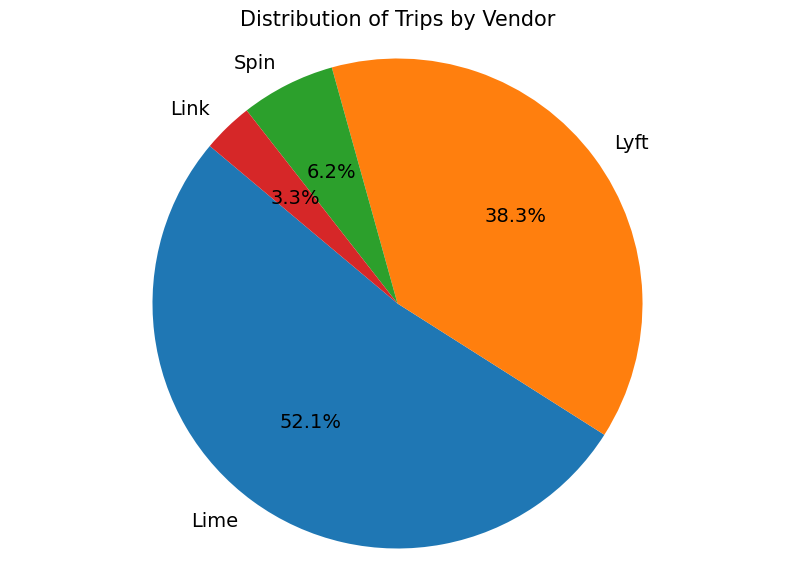

In [64]:
# Generate the pie chart
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.pie(vendor_counts, labels=vendor_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
plt.title('Distribution of Trips by Vendor', fontsize = 15)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Display the chart
plt.show()

### Vendor Distribution Analysis

In [65]:
# Calculate the percentage of trips by each vendor
vendor_distribution = df_e_scooter_trips['Vendor'].value_counts(normalize = True) * 100
print(vendor_distribution)

Vendor
Lime    52.110969
Lyft    38.322075
Spin     6.233664
Link     3.333292
Name: proportion, dtype: float64


In [66]:
df_e_scooter_trips['Start Community Area Name'].value_counts()

Start Community Area Name
Near North Side    479130
Near West Side     409160
Loop               353414
West Town          288500
Lincoln Park       265325
                    ...  
Forest Glen          1788
Burnside             1482
Edison Park          1051
Mount Greenwood       643
Ohare                 496
Name: count, Length: 77, dtype: int64

We need to prepare data from the df_e_scooter_trips and df_weather datasets. First, we extract relevant features such as the hour of the day and day of the week from the timestamps, and merge the e-scooter data with weather conditions.

In [67]:
# Count variable added
df_e_scooter_trips['eda_count'] = 1

In [68]:
# Correct datetime format to match the date strings
datetime_format = '%m/%d/%Y %I:%M:%S %p'  # Adjusting to match "MM/DD/YYYY HH:MM:SS AM/PM"

# Convert 'Start Time' and 'End Time' to datetime using the correct format
df_e_scooter_trips['Start Time'] = pd.to_datetime(df_e_scooter_trips['Start Time'], format=datetime_format)
df_e_scooter_trips['End Time'] = pd.to_datetime(df_e_scooter_trips['End Time'], format=datetime_format)

# Extract hour of day and day of the week
df_e_scooter_trips['hour_of_day'] = df_e_scooter_trips['Start Time'].dt.hour
df_e_scooter_trips['day_of_week'] = df_e_scooter_trips['Start Time'].dt.dayofweek
df_e_scooter_trips['is_weekend'] = df_e_scooter_trips['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

In [69]:
# Ensure it's datetime format
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

# Prepare df_e_scooter_trips for merging
df_e_scooter_trips['date_for_merge'] = df_e_scooter_trips['Start Time'].dt.normalize()

# Perform the merge
df_e_scooter_trips = pd.merge(df_e_scooter_trips, df_weather, left_on='date_for_merge', right_on='datetime', how='left')

# Drop the temporary merging column
df_e_scooter_trips.drop('date_for_merge', axis=1, inplace=True)

### Type of riders partition

In [70]:
from itertools import chain

# Type of riders
# Dictionary for time segments
time_segments = {
    'Morning Commutes': range(5, 11),  # 5 AM to 10 AM
    'Lunchtime Travelers': range(11, 16),  # 10 AM to 3 PM
    'Afternoon Riders': range(16, 21),  # 3 PM to 8 PM
    'Late Night Riders': list(chain(range(21, 24), range(0, 1)))  # 8 PM to Midnight to 1 AM
}

# Lambda function to segment the times
df_e_scooter_trips['type_of_rider'] = df_e_scooter_trips['hour_of_day'].apply(lambda x: next((segment for segment, hours in time_segments.items() if x in hours), None))

# Group by segment and sum the counts
segmented_data = df_e_scooter_trips.groupby('type_of_rider')['eda_count'].sum().reset_index()
sorted_segmented_data = segmented_data.sort_values(by = 'eda_count')
sorted_segmented_data

,type_of_rider,eda_count
3,Morning Commutes,564087
1,Late Night Riders,587900
2,Lunchtime Travelers,1068504
0,Afternoon Riders,1576550


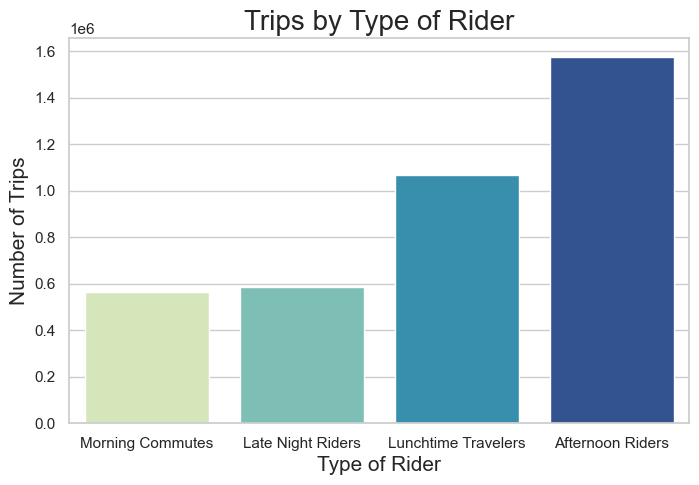

In [71]:
# Creating graph showing the number of electric scooter trips by hour in the day
plt.figure(figsize = (8, 5))
sns.set(style = 'whitegrid')

# Plot
eda_data_plot = sns.barplot(x = 'type_of_rider', y = 'eda_count', data = sorted_segmented_data, palette="YlGnBu" )

# Labels and titles
plt.title('Trips by Type of Rider', fontsize = 20)
plt.xlabel('Type of Rider', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.show()

In [72]:
df_e_scooter_trips_plot = df_e_scooter_trips.groupby('hour_of_day').sum(numeric_only=True).reset_index()
df_e_scooter_trips_plot.head()

,hour_of_day,Trip Distance,Trip Duration,Start Community Area Number,End Community Area Number,Start Centroid Latitude,Start Centroid Longitude,End Centroid Latitude,End Centroid Longitude,eda_count,day_of_week,is_weekend,temp,precip,snow
0,0,132616397,47345621,1291093.0,1285752.0,2.197761e+06,-4.599212e+06,2.198108e+06,-4.599992e+06,52513,191371,23334,3653104.1,6192.805,168.0
1,1,278601,123792,2558.0,2559.0,4.188226e+03,-8.768162e+03,4.187877e+03,-8.767900e+03,100,306,33,6761.8,4.506,0.0
2,2,2411890,71043,1103.0,1125.0,1.549065e+03,-3.244520e+03,1.549037e+03,-3.244431e+03,38,145,19,2566.9,3.662,0.0
3,3,74786,35927,787.0,767.0,1.088637e+03,-2.280467e+03,1.088677e+03,-2.280416e+03,26,111,15,1742.4,0.847,0.0
4,4,123865,58085,787.0,814.0,1.340901e+03,-2.806448e+03,1.340906e+03,-2.806750e+03,32,102,11,2163.2,0.542,0.0


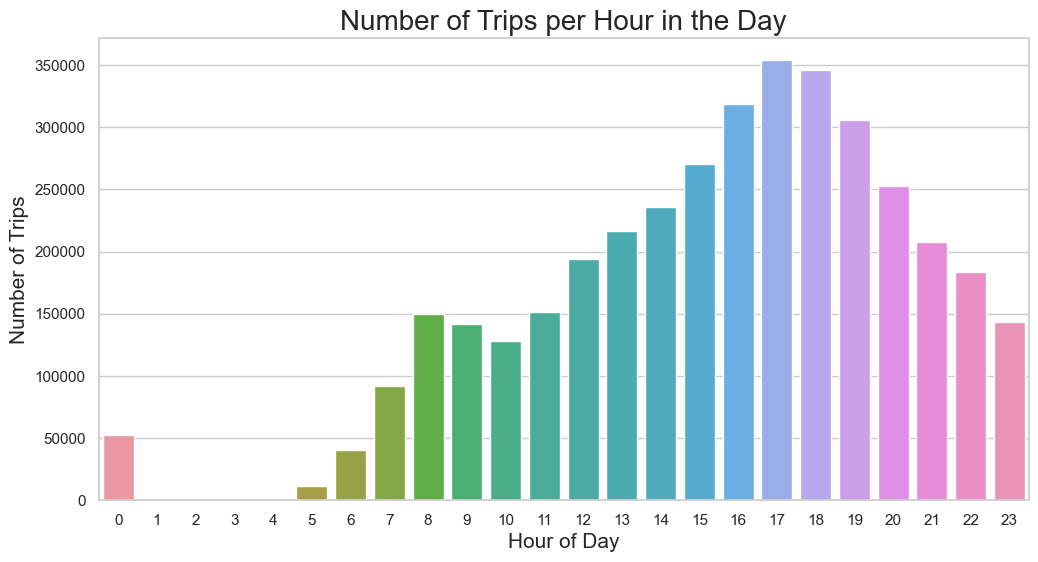

In [73]:
# Creating graph showing the number of electric scooter trips by hour in the day
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

# Plot
eda_data_plot = sns.barplot(x = 'hour_of_day', y = 'eda_count', data = df_e_scooter_trips_plot)

# Labels and titles
plt.title('Number of Trips per Hour in the Day', fontsize = 20)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.show()

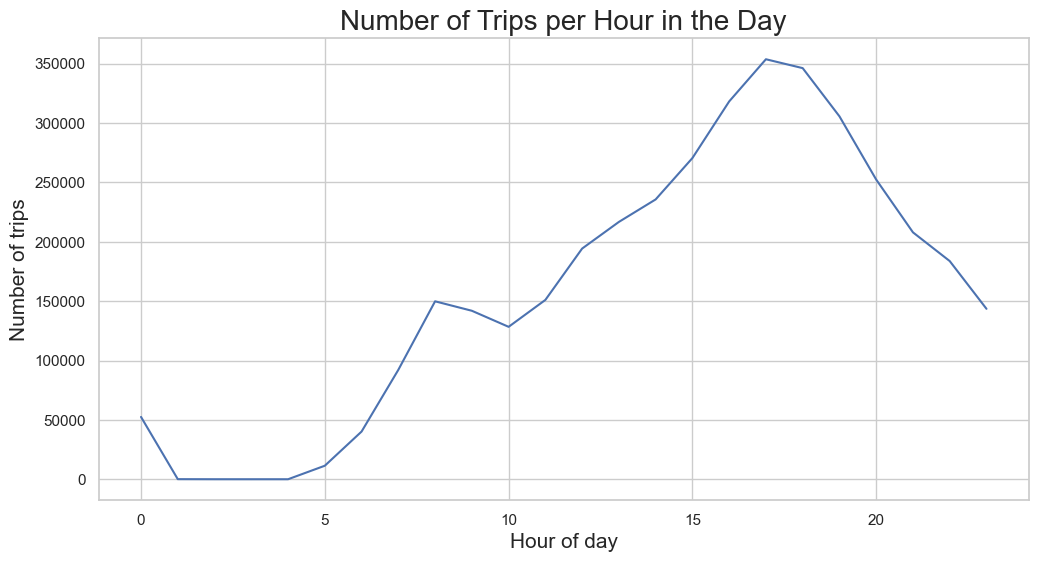

In [74]:
# Line plot
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

graph1 = sns.lineplot(x = 'hour_of_day', y = 'eda_count', data = df_e_scooter_trips_plot)

# Titles and labels
plt.title('Number of Trips per Hour in the Day', fontsize = 20)
plt.xlabel('Hour of day', fontsize = 15)
plt.ylabel('Number of trips', fontsize = 15)

plt.show()

Demand per Area and Time:
   Start Community Area Name  hour_of_day  demand_count
0                Albany Park            0           419
1                Albany Park            4             1
2                Albany Park            5            78
3                Albany Park            6           227
4                Albany Park            7           624
5                Albany Park            8           944
6                Albany Park            9           945
7                Albany Park           10           936
8                Albany Park           11          1100
9                Albany Park           12          1176
10               Albany Park           13          1341
11               Albany Park           14          1582
12               Albany Park           15          2052
13               Albany Park           16          2020
14               Albany Park           17          2049
15               Albany Park           18          1912
16               Alban

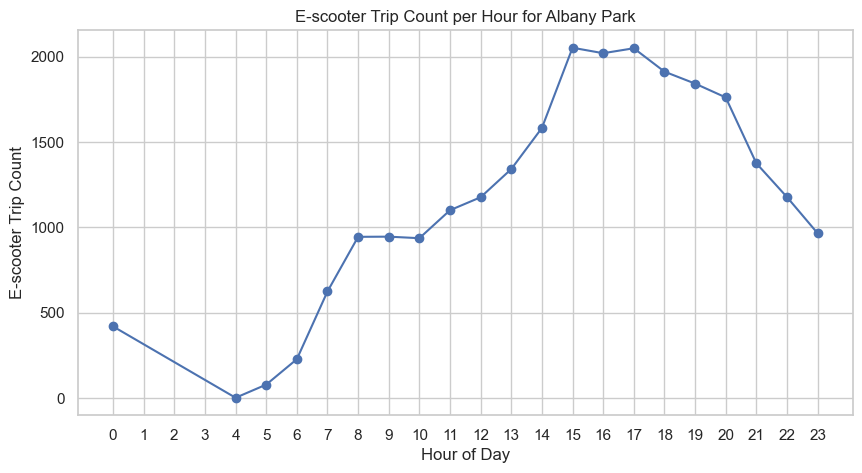

In [75]:
# Ensure all necessary columns are present
if 'Start Community Area Name' in df_e_scooter_trips.columns:
    # Group by community area and hour to aggregate trip counts
    demand_per_area_time = df_e_scooter_trips.groupby(['Start Community Area Name', 'hour_of_day']).size().reset_index(name='demand_count')

    # Sorting the results for better readability
    demand_per_area_time = demand_per_area_time.sort_values(by=['Start Community Area Name', 'hour_of_day'])

    # Display the demand data
    print("Demand per Area and Time:")
    print(demand_per_area_time.head(50))  # Adjust the number to display more or fewer rows as needed
else:
    print("The column 'Start Community Area Name' does not exist in the dataset.")

# For demonstration, visualize the first community area's data
first_area_name = demand_per_area_time['Start Community Area Name'].iloc[0]
area_data = demand_per_area_time[demand_per_area_time['Start Community Area Name'] == first_area_name]

plt.figure(figsize=(10, 5))
plt.plot(area_data['hour_of_day'], area_data['demand_count'], marker='o')
plt.title(f'E-scooter Trip Count per Hour for {first_area_name}')
plt.xlabel('Hour of Day')
plt.ylabel('E-scooter Trip Count')
plt.grid(True)
plt.xticks(range(0, 24))  # Set x-axis ticks to show every hour
plt.show()

#### Number of Trips by Community

In [76]:
import geopandas as gpd
import matplotlib.pyplot as plt
#!pip install folium
import folium
from folium import Choropleth

shapefile_path = 'Chicago city Boundaries/geo_export_777ed415-6a0c-431d-ac1e-a7b3240d2e21.shp'
gdf_community_areas = gpd.read_file(shapefile_path)

count_of_trips = start_demand.groupby('Start Community Area Number').agg({'trip_count': 'sum'}).reset_index()
count_of_trips.columns = ['community_area_number', 'count_trip']

# Convert 'area_num_1' to integer in gdf_community_areas
gdf_community_areas['area_num_1'] = gdf_community_areas['area_num_1'].astype(int)

# Merge both dataframes to get shape details from shp file
merged_gdf = gdf_community_areas.merge(count_of_trips, how='left', left_on='area_num_1', right_on='community_area_number')


In [77]:
gdf_community_areas

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


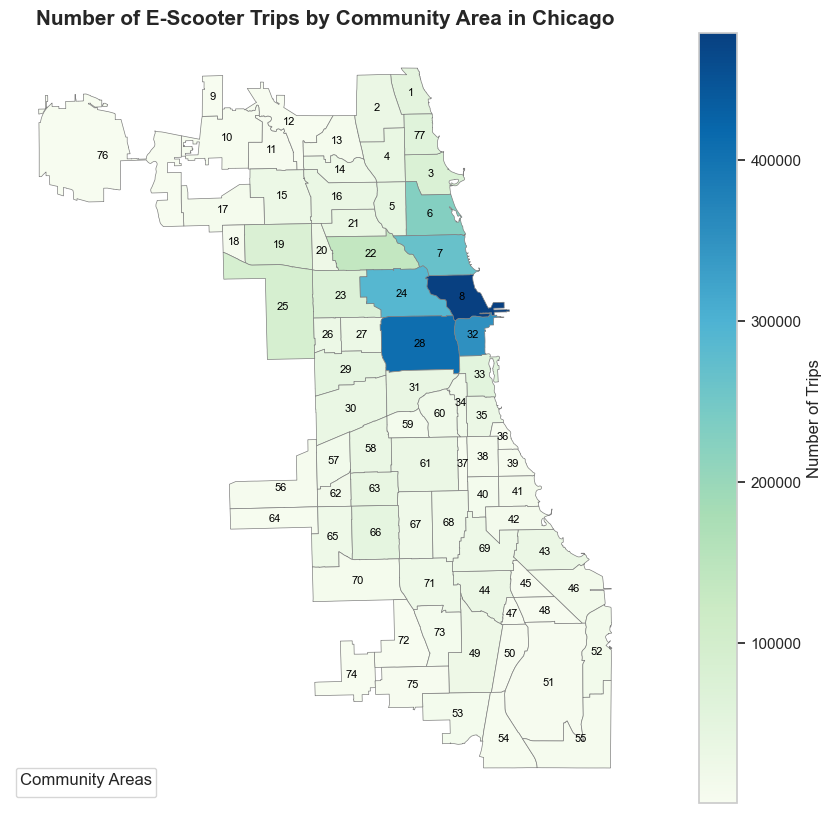

In [78]:
# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Choose a colormap (e.g., 'GnBu')
cmap = 'GnBu'

# Plot GeoDataFrame with community area boundaries and color-coded by 'count_trip'
merged_gdf.plot(column='count_trip', ax=ax, legend=False, cmap=cmap, edgecolor='grey', linewidth=0.5)

# Adding community area numbers as labels
for idx, row in merged_gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, str(row['area_num_1']),
            horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')

# Adding a title
ax.set_title('Number of E-Scooter Trips by Community Area in Chicago', fontdict={'fontsize': 15, 'fontweight': 'bold'})
ax.set_axis_off()  # Turn off axis

# Manually create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=merged_gdf['count_trip'].min(), vmax=merged_gdf['count_trip'].max()))
sm._A = []  # This creates the color bar without any data

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Number of Trips', fontsize=12)

# Create a legend for community area numbers and names
legend_labels = [f"{num}: {name}" for num, name in zip(merged_gdf['area_num_1'], merged_gdf['community'])]
ax.legend(handles=[], labels=legend_labels, title='Community Areas', loc='lower left', fontsize=8)

# Show plot
plt.show()

### Number of Bus Stops and Train Stops per Community Area

In [79]:
#Finding the number of bus stops and train stops in each community
bus_train_count = start_demand[['Start Community Area Number', 'bus_stops', 'train_stops']].drop_duplicates().reset_index(drop = True)

# Sort and select the top 10 for bus and train stops
top_10_bus_stops = bus_train_count.nlargest(10, 'bus_stops')
top_10_train_stops = bus_train_count.nlargest(10, 'train_stops')

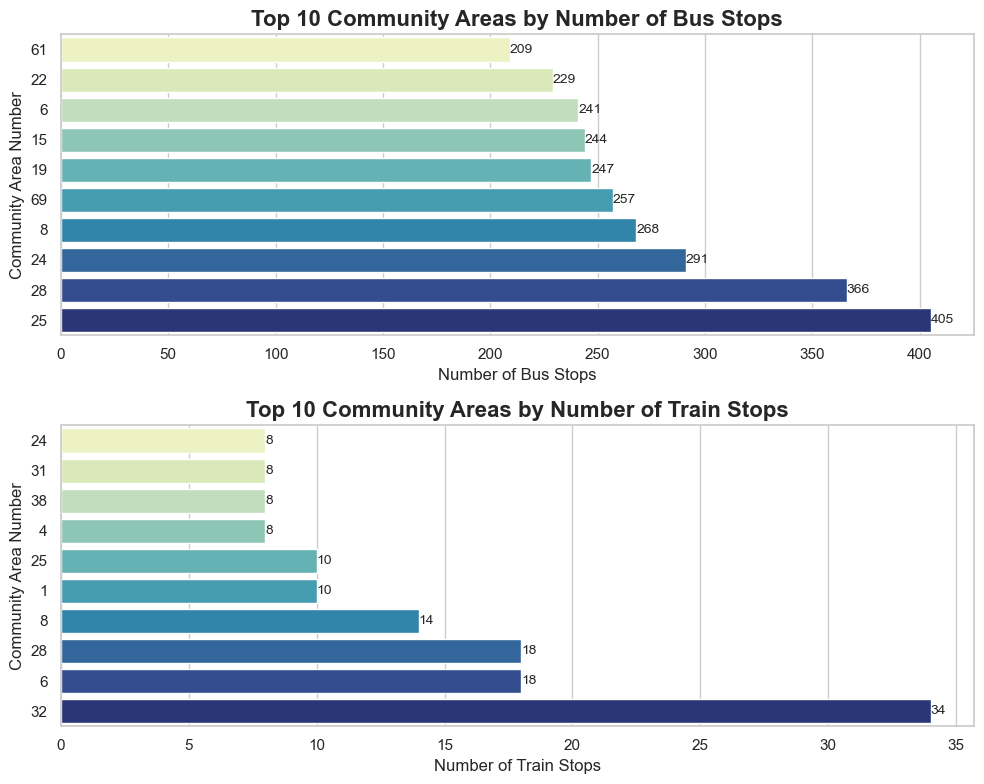

In [80]:
# Set plot style
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot for bus stops
sns.barplot(x='bus_stops', y='Start Community Area Number', data=top_10_bus_stops, orient = 'h', ax=ax1, 
            palette="YlGnBu", order=top_10_bus_stops.sort_values('bus_stops', ascending=True)['Start Community Area Number'])
ax1.set_title('Top 10 Community Areas by Number of Bus Stops', fontsize=16, fontweight='bold')
ax1.set_xlabel('Number of Bus Stops')
ax1.set_ylabel('Community Area Number')
ax1.bar_label(ax1.containers[0], label_type='edge', fontsize=10)

# Plot for train stops
sns.barplot(x='train_stops', y='Start Community Area Number', data=top_10_train_stops, orient = 'h', ax=ax2, 
            palette = "YlGnBu", order = top_10_train_stops.sort_values('train_stops', ascending=True)['Start Community Area Number'])
ax2.set_title('Top 10 Community Areas by Number of Train Stops', fontsize=16, fontweight='bold')
ax2.set_xlabel('Number of Train Stops')
ax2.set_ylabel('Community Area Number')
ax2.bar_label(ax2.containers[0], label_type='edge', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Median Household Income by Community Area

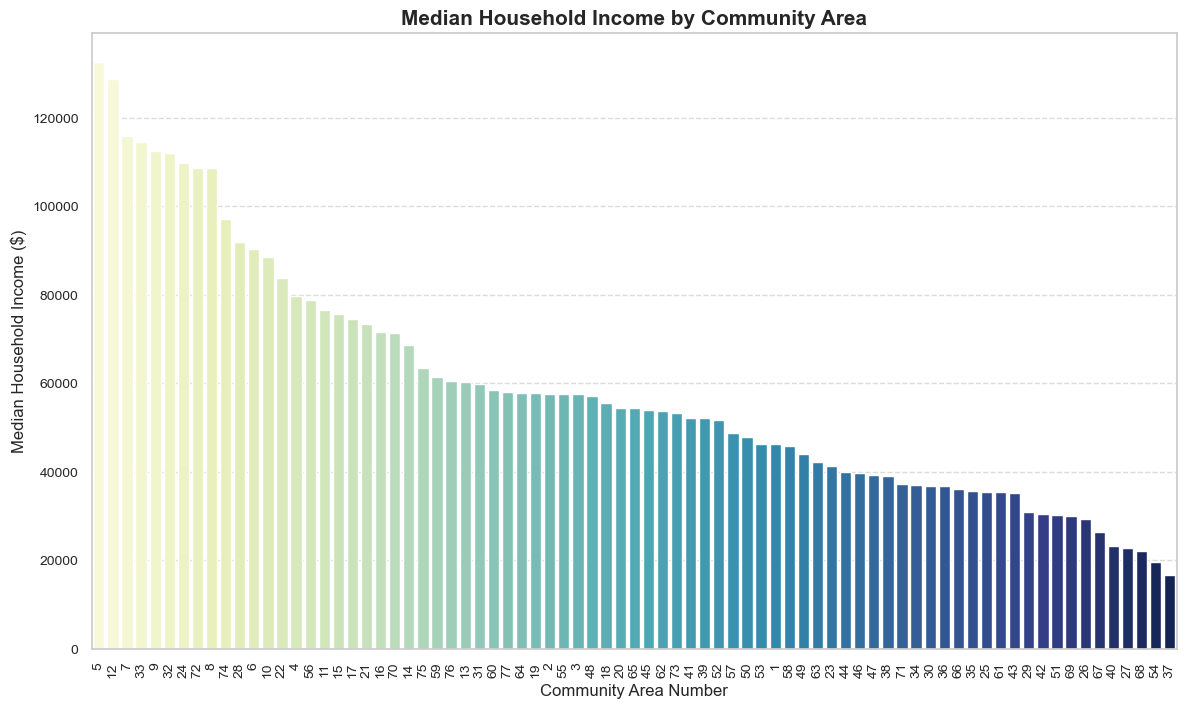

In [81]:
import matplotlib.ticker as mticker

# Prepare the DataFrame, ensuring unique community areas
income_df = start_demand[['Start Community Area Number', 'median_household_income']].drop_duplicates()

# Sort the DataFrame by median household income in descending order
income_df_sorted = income_df.sort_values(by ='median_household_income', ascending=False)

# Create a custom order list based on sorted community areas
custom_order = income_df_sorted['Start Community Area Number'].tolist()

# Create the plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Start Community Area Number', y ='median_household_income', data = income_df_sorted, palette='YlGnBu',
            order=custom_order)  # Use custom order for x-axis

# Adding titles and labels
plt.title('Median Household Income by Community Area', fontsize = 15, fontweight='bold')
plt.xlabel('Community Area Number', fontsize = 12)
plt.ylabel('Median Household Income ($)', fontsize=12)
plt.xticks(rotation = 90, fontsize = 10)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize = 10)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


### Crimes per community ###

In [82]:
# Group by 'Start Community Area Number' and sum up the 'total_crimes'
total_crimes_by_community = start_demand.groupby('Start Community Area Number')['total_crimes'].sum().reset_index()

# Rename the columns for clarity
total_crimes_by_community.columns = ['Community Area', 'Total Crimes']

# Drop rows with NaN values in 'Community Area' column
total_crimes_by_community.dropna(subset=['Community Area'], inplace=True)

# Sort the data in descending order of 'Total Crimes'
sorted_crimes = total_crimes_by_community.sort_values('Total Crimes')


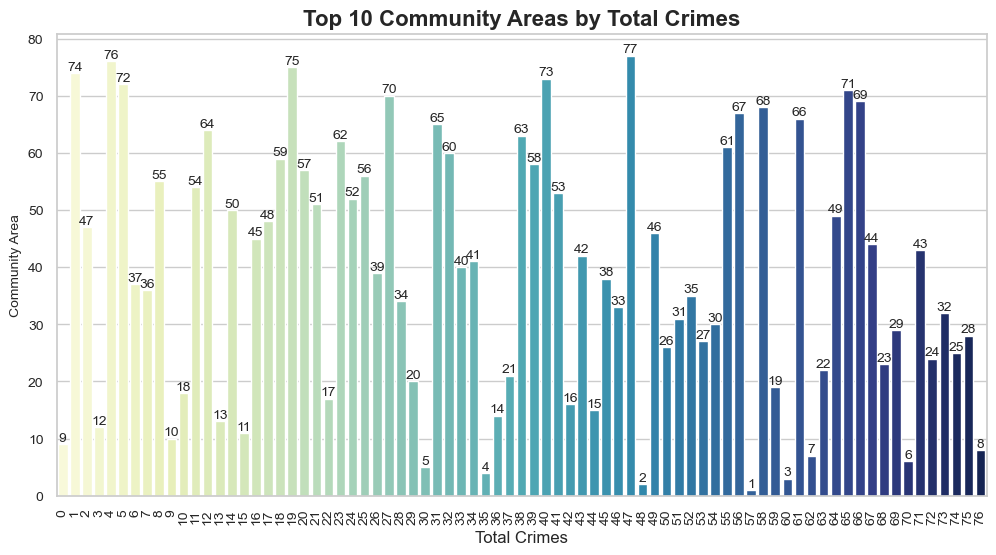

In [83]:
# Custom formatter function to format numbers with commas
def format_with_comma(value, pos):
    return f'{int(value):,}'

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Total Crimes', y='Community Area', data=sorted_crimes, palette="YlGnBu")

# Add title and labels
plt.title('Top 10 Community Areas by Total Crimes', fontsize=16, fontweight='bold')
plt.xlabel('Total Crimes', fontsize=12)
plt.ylabel('Community Area', fontsize=10)

# Apply the custom formatter to x-axis
bar_plot.xaxis.set_major_formatter(mticker.FuncFormatter(format_with_comma))

# Add data labels to each bar
for container in bar_plot.containers:
    bar_plot.bar_label(container, labels=[format_with_comma(val, None) for val in container.datavalues], label_type='edge', fontsize=10)

# Rotate x-axis labels for readability
plt.xticks(rotation = 90, fontsize = 10)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize = 10)

# Show the plot
plt.show()

### Correlation between Number of Trips and exogenous variables ###

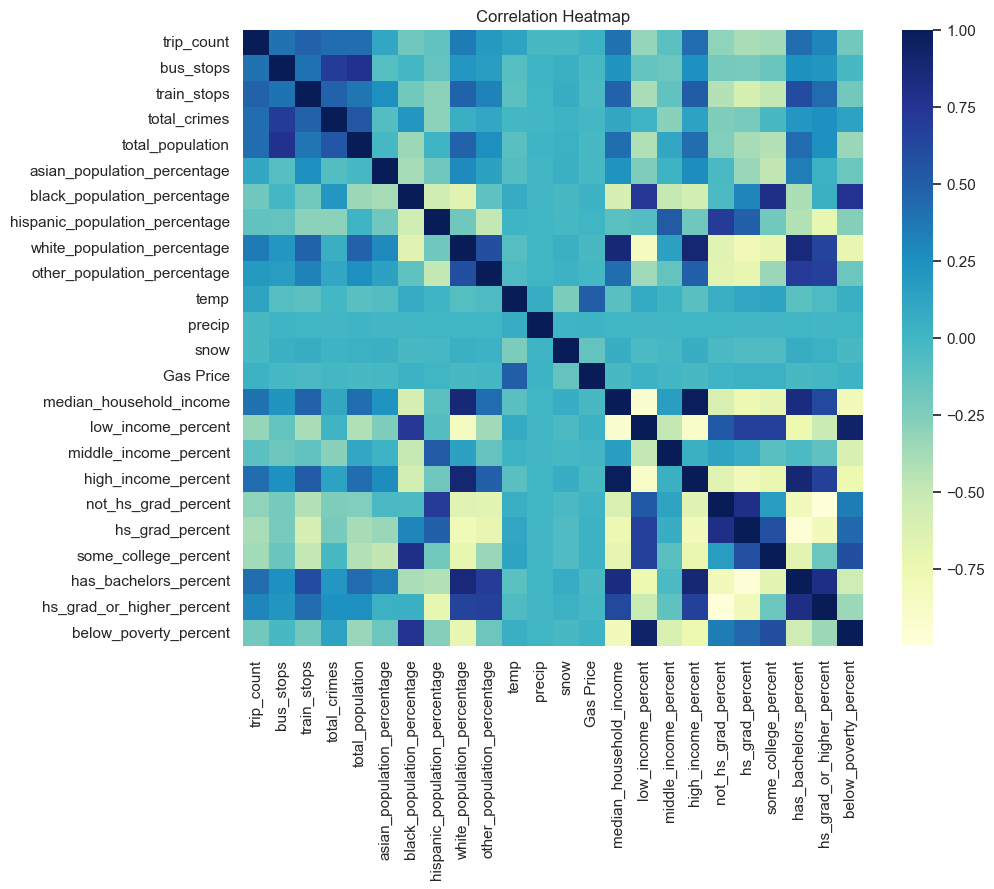

In [84]:
# Select numerical columns only for correlation
numerical_columns = [
    'trip_count', 'bus_stops', 'train_stops', 'total_crimes',
    'total_population', 'asian_population_percentage',
    'black_population_percentage', 'hispanic_population_percentage',
    'white_population_percentage', 'other_population_percentage',
    'temp', 'precip', 'snow', 'Gas Price', 'median_household_income',
    'low_income_percent', 'middle_income_percent', 'high_income_percent',
    'not_hs_grad_percent', 'hs_grad_percent', 'some_college_percent',
    'has_bachelors_percent', 'hs_grad_or_higher_percent',
    'below_poverty_percent'
]

# Calculate the correlation matrix
correlation_matrix = start_demand[numerical_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='YlGnBu', center=0)
plt.title('Correlation Heatmap')
plt.show()

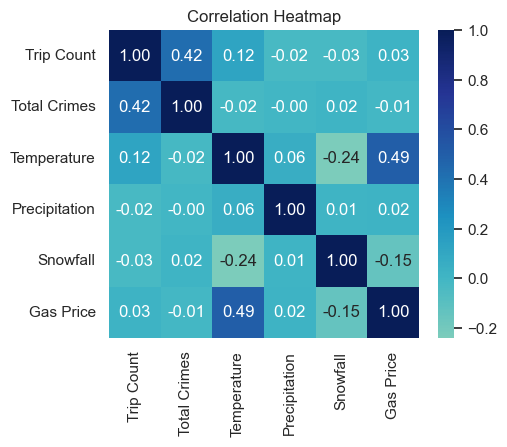

In [160]:
# Select numerical columns only for correlation
numerical_columns = [
    'trip_count', 'total_crimes','temp', 'precip', 'snow', 'Gas Price']

new_names = {
    'trip_count': 'Trip Count',
    'total_crimes': 'Total Crimes',
    'temp': 'Temperature',
    'precip': 'Precipitation',
    'snow': 'Snowfall',
    'Gas Price': 'Gas Price'
}

# Calculate the correlation matrix
correlation_matrix = start_demand[numerical_columns].corr()

# Rename the columns and index of the correlation matrix
correlation_matrix.rename(columns=new_names, index=new_names, inplace=True)

# Create a heatmap with annotations
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='YlGnBu', center=0)
plt.title('Correlation Heatmap')
plt.show()

### Variable Selection ###

In [86]:
# Through Pearson correlations

# Calculate correlations with trip_count
correlations = start_demand.corr()['trip_count'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > 0.05].index  # Example threshold

print(selected_features)

Index(['trip_count', 'train_stops', 'has_bachelors_percent', 'total_crimes',
       'total_population', 'high_income_percent', 'median_household_income',
       'bus_stops', 'hs_grad_percent', 'some_college_percent',
       'white_population_percentage', 'low_income_percent',
       'not_hs_grad_percent', 'hs_grad_or_higher_percent',
       'Start Community Area Number', 'below_poverty_percent',
       'other_population_percentage', 'black_population_percentage',
       'hispanic_population_percentage', 'temp', 'asian_population_percentage',
       'middle_income_percent', 'trip_start', 'datetime', 'Trip Date'],
      dtype='object')


In [87]:
# Mutual information Method
from sklearn.feature_selection import mutual_info_regression

recursive_df = start_demand[numerical_columns].drop('trip_count', axis=1)

# Calculate mutual information for numerical variables
mutual_info = mutual_info_regression(recursive_df, start_demand['trip_count'])
mutual_info_series = pd.Series(mutual_info, index = recursive_df.columns)
selected_features = mutual_info_series.sort_values(ascending=False).index

print(selected_features)

Index(['total_crimes', 'Gas Price', 'temp', 'precip', 'snow'], dtype='object')


In [88]:
# Checking the important variables through Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

recursive_df = start_demand[numerical_columns].drop('trip_count', axis=1)

# Define model and RFE
model = LinearRegression()
rfe = RFE(model, n_features_to_select=15)  # Select top 5 features
rfe.fit(recursive_df, start_demand['trip_count'])

selected_features = recursive_df.columns[rfe.support_]
print(selected_features)

Index(['total_crimes', 'temp', 'precip', 'snow', 'Gas Price'], dtype='object')


## Data Preprocessing

## Train/Test Split for Modeling

In [89]:
# Sort data by time
start_demand.sort_values('trip_start', inplace=True)

# Define the split date
# Train = May 10, 2022 to June 30, 2023
# Test = July 1, 2023 to Sept 29, 2023
train_end_date = '2023-06-30' 

# Split the data
train_data = start_demand[start_demand['trip_start'] <= train_end_date]
test_data = start_demand[start_demand['trip_start'] > train_end_date]

#train_data.to_csv('train_hourly_demand.csv', index=False)
#test_data.to_csv('test_hourly_demand.csv', index=False)

# Printing sizes
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 294321
Test set size: 106835


### Exogenous variables

In [90]:
exog_vars = start_demand[['temp', 'precip', 'snow', 'Gas Price', 'asian_population_percentage',
                           'black_population_percentage','not_hs_grad_percent','hs_grad_percent','some_college_percent','has_bachelors_percent',
                           'total_crimes', 'bus_stops', 'train_stops','hispanic_population_percentage','white_population_percentage','median_household_income']]

### Implementing the ARIMAX Model for 1 Community - Community area number 8 ###

#### Plot the Time series train data ####

In [91]:
start_demand8 = start_demand[start_demand['Start Community Area Number'] == 1]

# Convert tge trip_start to datetime format
start_demand8['trip_start'] = pd.to_datetime(start_demand8['trip_start'])

# Set 'trip_start' as the index
start_demand8.set_index('trip_start', inplace=True)

/var/folders/gv/9rdl5b851912bg6vpps84lh40000gn/T/ipykernel_19338/3271793984.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_demand8['trip_start'] = pd.to_datetime(start_demand8['trip_start'])


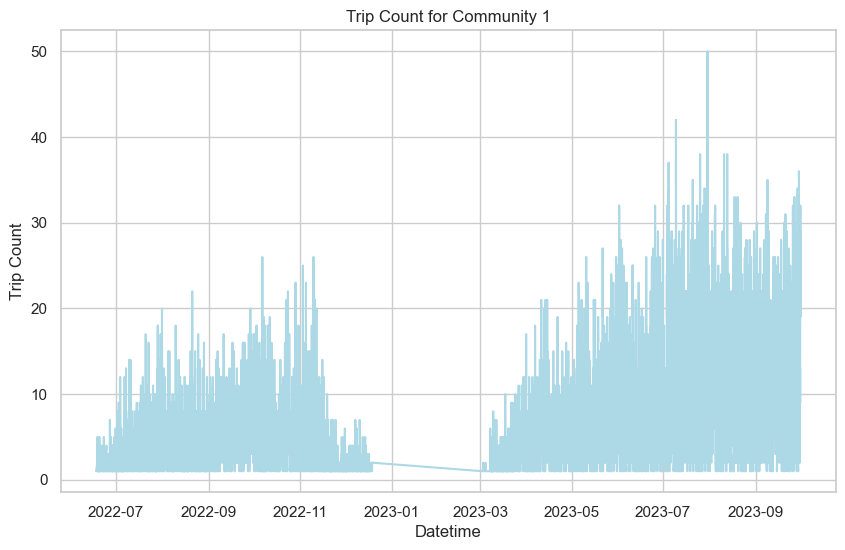

In [92]:
# Plotting the time series data
plt.figure(figsize=(10, 6))
sns.lineplot(x='trip_start', y='trip_count', data=start_demand8, color = 'lightblue')
plt.xlabel('Datetime')
plt.ylabel('Trip Count')
plt.title('Trip Count for Community 1')
plt.grid(True)
plt.show()

In [93]:
start_demand[start_demand['Start Community Area Number'] == 1]

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,...,median_household_income,low_income_percent,middle_income_percent,high_income_percent,not_hs_grad_percent,hs_grad_percent,some_college_percent,has_bachelors_percent,hs_grad_or_higher_percent,below_poverty_percent
358428,2022-06-17 17:00:00,1,1,105,10.0,2022-06-17,18.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
358429,2022-06-17 19:00:00,1,1,105,10.0,2022-06-17,18.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
358430,2022-06-18 11:00:00,1,2,105,10.0,2022-06-18,12.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
358431,2022-06-18 12:00:00,1,2,105,10.0,2022-06-18,12.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
358432,2022-06-18 13:00:00,1,2,105,10.0,2022-06-18,12.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365203,2023-09-30 15:00:00,1,32,105,10.0,2023-09-30,3.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
365204,2023-09-30 16:00:00,1,19,105,10.0,2023-09-30,3.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
365205,2023-09-30 17:00:00,1,29,105,10.0,2023-09-30,3.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
365206,2023-09-30 18:00:00,1,20,105,10.0,2023-09-30,3.0,55643,5.423863,27.063602,...,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679


The plot shows seasonality and a slight upward trend. Hence from observing the plot, the data is non-stationary. We can verify this with KPSS test. 

#### ACF Plot and PACF Plot ####

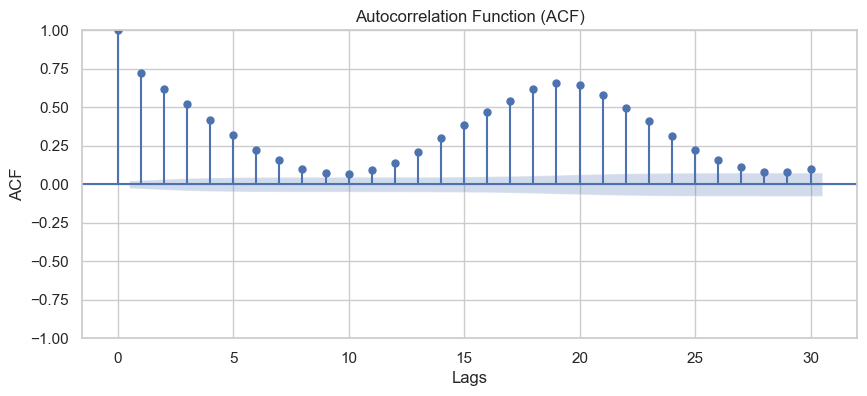

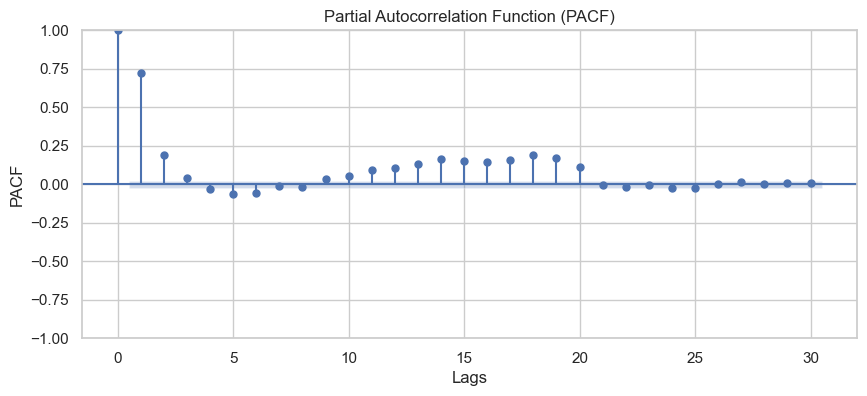

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(10, 4))
plot_acf(start_demand8['trip_count'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(10, 4))
plot_pacf(start_demand8['trip_count'], lags=30, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

Here the stickiness of ACF plot shows that the data is in a positive direction. The slowly decaying and periodic ACF plot shows the presence of seasonality. The seasonal lag is large and positive at multiples of 8.

#### KPSS Test to verify Stationarity ####

In [95]:
# import kpss
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
kpss_result = kpss(start_demand8['trip_count'], regression='c', nlags='auto')

# Output the KPSS test results
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Lags Used:', kpss_result[2])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'   {key} : {value}')

KPSS Statistic: 11.422640289962287
p-value: 0.01
Lags Used: 41
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/var/folders/gv/9rdl5b851912bg6vpps84lh40000gn/T/ipykernel_19338/914170451.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(start_demand8['trip_count'], regression='c', nlags='auto')


since p-value is 0.01, which is less than 0.05, we can reject the null hypothesis. Hence taking the alternative hypothesis, which states that **the data is non-stationary**.

In [96]:
# Convert 'trip_start' to datetime format
train_data['trip_start'] = pd.to_datetime(train_data['trip_start'])

# Set 'trip_start' as the index
train_data.set_index('trip_start', inplace=True)

# Convert 'trip_start' to datetime format
test_data['trip_start'] = pd.to_datetime(test_data['trip_start'])

# Set 'trip_start' as the index
test_data.set_index('trip_start', inplace=True)


/var/folders/gv/9rdl5b851912bg6vpps84lh40000gn/T/ipykernel_19338/4111502513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['trip_start'] = pd.to_datetime(train_data['trip_start'])
/var/folders/gv/9rdl5b851912bg6vpps84lh40000gn/T/ipykernel_19338/4111502513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['trip_start'] = pd.to_datetime(test_data['trip_start'])


In [97]:
# Running ARIMAX for community 8
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


train_startdemand_8 = train_data[train_data['Start Community Area Number'] == 1]
train_startdemand_8

,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,hispanic_population_percentage,white_population_percentage,other_population_percentage,datetime,temp,precip,snow,Gas Price,median_household_income,low_income_percent,middle_income_percent,high_income_percent,not_hs_grad_percent,hs_grad_percent,some_college_percent,has_bachelors_percent,hs_grad_or_higher_percent,below_poverty_percent
trip_start,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-17 17:00:00,1,1,105,10.0,2022-06-17,18.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2022-06-17,78.9,0.000,0.0,5.803,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2022-06-17 19:00:00,1,1,105,10.0,2022-06-17,18.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2022-06-17,78.9,0.000,0.0,5.803,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2022-06-18 11:00:00,1,2,105,10.0,2022-06-18,12.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2022-06-18,67.2,0.000,0.0,5.803,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2022-06-18 12:00:00,1,2,105,10.0,2022-06-18,12.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2022-06-18,67.2,0.000,0.0,5.803,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2022-06-18 13:00:00,1,2,105,10.0,2022-06-18,12.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2022-06-18,67.2,0.000,0.0,5.803,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29 20:00:00,1,8,105,10.0,2023-06-29,11.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-06-29,78.3,0.039,0.0,4.191,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2023-06-29 21:00:00,1,11,105,10.0,2023-06-29,11.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-06-29,78.3,0.039,0.0,4.191,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2023-06-29 22:00:00,1,8,105,10.0,2023-06-29,11.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-06-29,78.3,0.039,0.0,4.191,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679


In [98]:
# Exogenous variables for the SARIMAX
exog_new = train_startdemand_8[['temp', 'precip', 'snow', 'Gas Price','total_crimes']]

**Note**: We selected only these many exog variables because the main criteria for exog variables are they should be **time varying**. When we consider all other features only the above features are time varying and only makes sense to use these above variables.

In [99]:
# # Test data for community 8
test_startdemand_8 = test_data[test_data['Start Community Area Number'] == 1]
test_startdemand_8

,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,hispanic_population_percentage,white_population_percentage,other_population_percentage,datetime,temp,precip,snow,Gas Price,median_household_income,low_income_percent,middle_income_percent,high_income_percent,not_hs_grad_percent,hs_grad_percent,some_college_percent,has_bachelors_percent,hs_grad_or_higher_percent,below_poverty_percent
trip_start,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-30 05:00:00,1,2,105,10.0,2023-06-30,7.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-06-30,80.1,0.001,0.0,4.191,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2023-06-30 06:00:00,1,1,105,10.0,2023-06-30,7.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-06-30,80.1,0.001,0.0,4.191,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2023-06-30 07:00:00,1,4,105,10.0,2023-06-30,7.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-06-30,80.1,0.001,0.0,4.191,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2023-06-30 08:00:00,1,14,105,10.0,2023-06-30,7.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-06-30,80.1,0.001,0.0,4.191,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2023-06-30 09:00:00,1,9,105,10.0,2023-06-30,7.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-06-30,80.1,0.001,0.0,4.191,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 15:00:00,1,32,105,10.0,2023-09-30,3.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-09-30,70.7,0.000,0.0,3.962,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2023-09-30 16:00:00,1,19,105,10.0,2023-09-30,3.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-09-30,70.7,0.000,0.0,3.962,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679
2023-09-30 17:00:00,1,29,105,10.0,2023-09-30,3.0,55643,5.423863,27.063602,18.936793,44.289488,4.286253,2023-09-30,70.7,0.000,0.0,3.962,46164,0.438473,0.446019,0.115508,0.116901,0.180075,0.231167,0.471858,0.883,0.215679


#### Periodogram ####

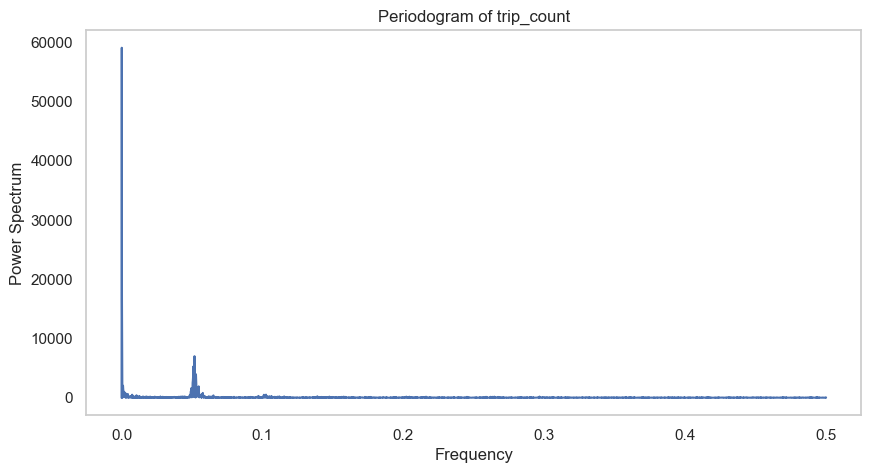

In [100]:
from scipy.signal import periodogram

# Extract the 'trip_count' time series
trip_count_p = start_demand8['trip_count'].values

# Compute the periodogram
frequencies, power_spectrum = periodogram(trip_count_p, fs=1.0)  # fs is the sampling frequency

# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.title('Periodogram of trip_count')
plt.grid()
plt.show()

In [101]:
# Set print options to disable scientific notation and increase threshold
np.set_printoptions(suppress=True, threshold=np.inf, precision=10)

# Print the entire frequencies array without scientific notation
print("Frequencies:\n", frequencies)

Frequencies:
 [0.           0.0001474926 0.0002949853 0.0004424779 0.0005899705
 0.0007374631 0.0008849558 0.0010324484 0.001179941  0.0013274336
 0.0014749263 0.0016224189 0.0017699115 0.0019174041 0.0020648968
 0.0022123894 0.002359882  0.0025073746 0.0026548673 0.0028023599
 0.0029498525 0.0030973451 0.0032448378 0.0033923304 0.003539823
 0.0036873156 0.0038348083 0.0039823009 0.0041297935 0.0042772861
 0.0044247788 0.0045722714 0.004719764  0.0048672566 0.0050147493
 0.0051622419 0.0053097345 0.0054572271 0.0056047198 0.0057522124
 0.005899705  0.0060471976 0.0061946903 0.0063421829 0.0064896755
 0.0066371681 0.0067846608 0.0069321534 0.007079646  0.0072271386
 0.0073746313 0.0075221239 0.0076696165 0.0078171091 0.0079646018
 0.0081120944 0.008259587  0.0084070796 0.0085545723 0.0087020649
 0.0088495575 0.0089970501 0.0091445428 0.0092920354 0.009439528
 0.0095870206 0.0097345133 0.0098820059 0.0100294985 0.0101769912
 0.0103244838 0.0104719764 0.010619469  0.0107669617 0.010914454

In general, it is recommended to forecast less than 5 values in advance, because the error in forecasts increases if we forecast far ahead in the future. This is because the ARIMA model uses the past values to predict the future values, and if we predict too much into the future, the error-prone predictions obtained previously would be used as training data.



## Prophet ##

### Trying out for single community (Community 8) ###

In [102]:
start_demand8 = start_demand[start_demand['Start Community Area Number'] == 8]
train_startdemand_8 = train_data[train_data['Start Community Area Number'] == 8]
# # Test data for community 8
test_startdemand_8 = test_data[test_data['Start Community Area Number'] == 8]
test_startdemand_8

,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,hispanic_population_percentage,white_population_percentage,other_population_percentage,datetime,temp,precip,snow,Gas Price,median_household_income,low_income_percent,middle_income_percent,high_income_percent,not_hs_grad_percent,hs_grad_percent,some_college_percent,has_bachelors_percent,hs_grad_or_higher_percent,below_poverty_percent
trip_start,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-30 05:00:00,8,7,268,14.0,2023-06-30,18.0,98528,14.301518,7.167506,6.191133,69.046362,3.29348,2023-06-30,80.1,0.001,0.0,4.191,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2023-06-30 06:00:00,8,28,268,14.0,2023-06-30,18.0,98528,14.301518,7.167506,6.191133,69.046362,3.29348,2023-06-30,80.1,0.001,0.0,4.191,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2023-06-30 07:00:00,8,55,268,14.0,2023-06-30,18.0,98528,14.301518,7.167506,6.191133,69.046362,3.29348,2023-06-30,80.1,0.001,0.0,4.191,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2023-06-30 08:00:00,8,67,268,14.0,2023-06-30,18.0,98528,14.301518,7.167506,6.191133,69.046362,3.29348,2023-06-30,80.1,0.001,0.0,4.191,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2023-06-30 09:00:00,8,65,268,14.0,2023-06-30,18.0,98528,14.301518,7.167506,6.191133,69.046362,3.29348,2023-06-30,80.1,0.001,0.0,4.191,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 16:00:00,8,142,268,14.0,2023-09-30,39.0,98528,14.301518,7.167506,6.191133,69.046362,3.29348,2023-09-30,70.7,0.000,0.0,3.962,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2023-09-30 17:00:00,8,124,268,14.0,2023-09-30,39.0,98528,14.301518,7.167506,6.191133,69.046362,3.29348,2023-09-30,70.7,0.000,0.0,3.962,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2023-09-30 18:00:00,8,186,268,14.0,2023-09-30,39.0,98528,14.301518,7.167506,6.191133,69.046362,3.29348,2023-09-30,70.7,0.000,0.0,3.962,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262


In [103]:
#Install and import prophet and related packages
#!pip install prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly

#Preparing the Train data for Prophet
train8_start_prophet = train_startdemand_8.reset_index()
train8_start_prophet = train8_start_prophet[['trip_start','trip_count','temp','precip','snow','Gas Price','total_crimes']].reset_index(drop = True)
train8_start_prophet = train8_start_prophet.rename(columns={'trip_start': 'ds', 'trip_count': 'y'})

#Preparing the Train data for Prophet
test8_start_prophet = test_startdemand_8.reset_index()
test8_start_prophet = test8_start_prophet[['trip_start','trip_count','temp','precip','snow','Gas Price','total_crimes']].reset_index(drop = True)
test8_start_prophet = test8_start_prophet.rename(columns={'trip_start': 'ds', 'trip_count': 'y'})
test8_start_prophet

,ds,y,temp,precip,snow,Gas Price,total_crimes
0,2023-06-30 05:00:00,7,80.1,0.001,0.0,4.191,18.0
1,2023-06-30 06:00:00,28,80.1,0.001,0.0,4.191,18.0
2,2023-06-30 07:00:00,55,80.1,0.001,0.0,4.191,18.0
3,2023-06-30 08:00:00,67,80.1,0.001,0.0,4.191,18.0
4,2023-06-30 09:00:00,65,80.1,0.001,0.0,4.191,18.0
...,...,...,...,...,...,...,...
1859,2023-09-30 16:00:00,142,70.7,0.000,0.0,3.962,39.0
1860,2023-09-30 17:00:00,124,70.7,0.000,0.0,3.962,39.0
1861,2023-09-30 18:00:00,186,70.7,0.000,0.0,3.962,39.0
1862,2023-09-30 19:00:00,108,70.7,0.000,0.0,3.962,39.0


In [104]:
# Modeling
m = Prophet(weekly_seasonality = True, yearly_seasonality = 'auto', seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10)
#m.add_country_holidays(country_name = 'US')
m.add_seasonality(name ='daily', period = 1, fourier_order = 5)
m.add_regressor('temp')
m.add_regressor('precip')
m.add_regressor('snow')
m.add_regressor('Gas Price')
m.add_regressor('total_crimes')

20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:30 - cmdstanpy - INFO - Chain [1] done processing


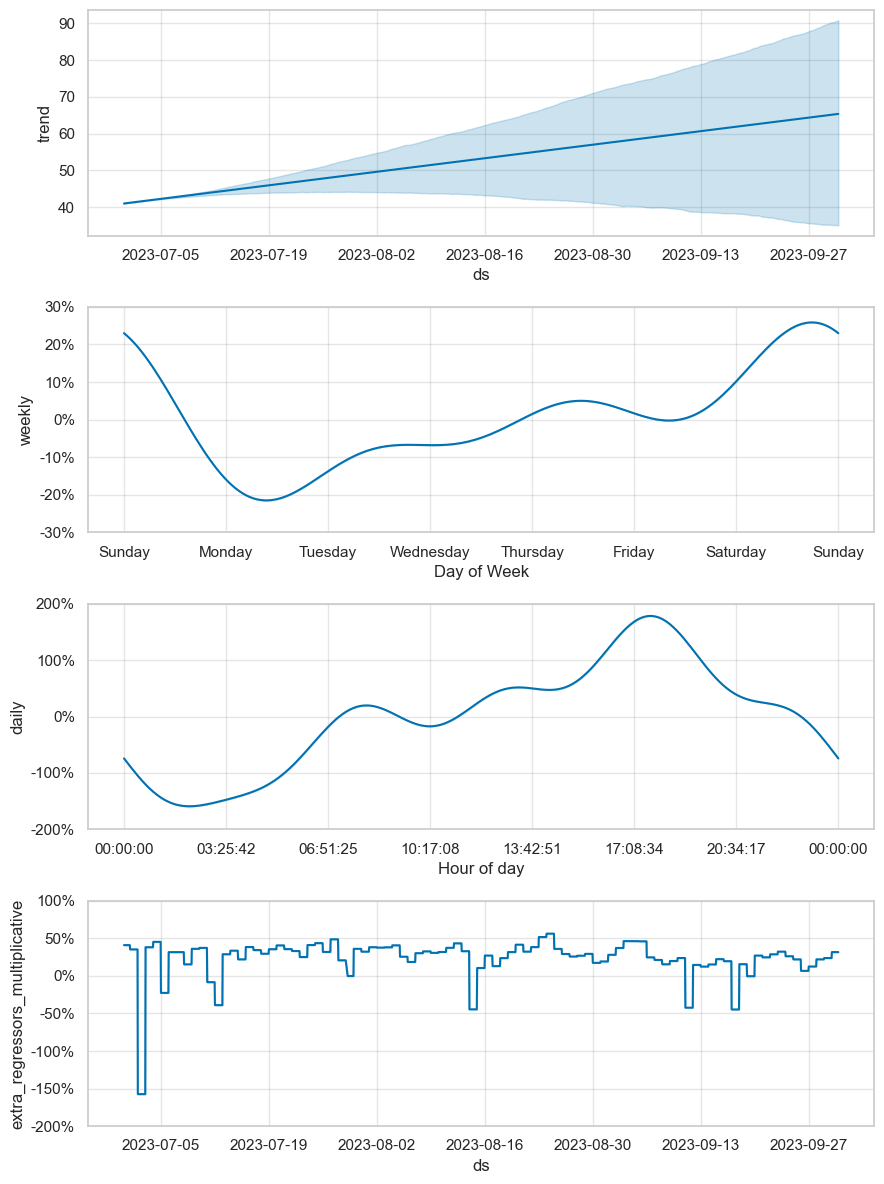

In [105]:
# Predicting using the model
m.fit(train8_start_prophet)
future   = test8_start_prophet.copy()
forecast = m.predict(future)
fig = m.plot_components(forecast)

In [106]:
# Forecasts with time and predicted trip_counts
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2023-06-30 05:00:00,10.479696,-11.643176,32.658262
1,2023-06-30 06:00:00,29.689001,6.413908,51.836560
2,2023-06-30 07:00:00,53.286231,29.401620,78.113457
3,2023-06-30 08:00:00,65.593535,43.093645,89.628255
4,2023-06-30 09:00:00,60.368348,37.377947,82.362616
...,...,...,...,...
1859,2023-09-30 16:00:00,170.259553,87.497057,239.698355
1860,2023-09-30 17:00:00,209.020515,111.189517,292.806902
1861,2023-09-30 18:00:00,217.292622,113.922817,304.797247
1862,2023-09-30 19:00:00,185.259713,98.504156,262.739631


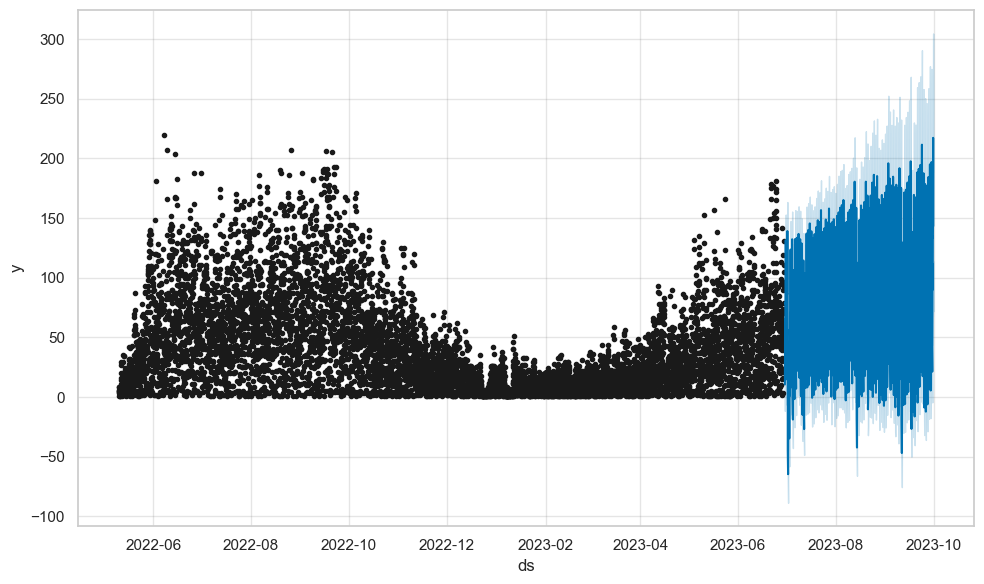

In [107]:
# Plotting Forecasts
fig1 = m.plot(forecast)

In [108]:
# Actual vs Predicted 
# Create the predicted DataFrame without setting 'trip_start' as an index
prophet_df = pd.DataFrame({
    'trip_start': forecast['ds'].values,
    'Predicted_count': forecast['yhat'].values,
    'Actual_count':test8_start_prophet['y'].values
})

prophet_df

,trip_start,Predicted_count,Actual_count
0,2023-06-30 05:00:00,10.479696,7
1,2023-06-30 06:00:00,29.689001,28
2,2023-06-30 07:00:00,53.286231,55
3,2023-06-30 08:00:00,65.593535,67
4,2023-06-30 09:00:00,60.368348,65
...,...,...,...
1859,2023-09-30 16:00:00,170.259553,142
1860,2023-09-30 17:00:00,209.020515,124
1861,2023-09-30 18:00:00,217.292622,186
1862,2023-09-30 19:00:00,185.259713,108


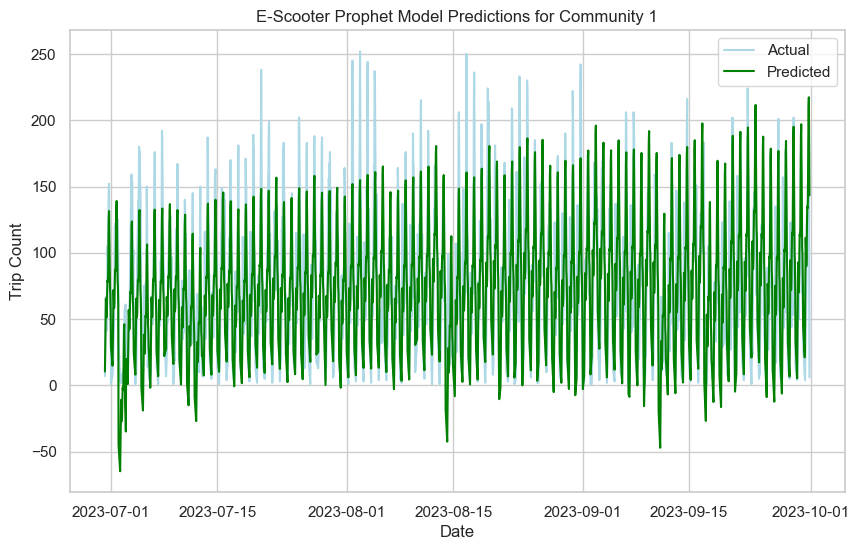

In [109]:
# Plotting The actual vs predicted for TBATS
plt.figure(figsize=(10, 6))
plt.plot(prophet_df['trip_start'], prophet_df['Actual_count'], label='Actual', color = 'lightblue')
plt.plot(prophet_df['trip_start'], prophet_df['Predicted_count'], label='Predicted', color='green')
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.title('E-Scooter Prophet Model Predictions for Community 1')
plt.legend()
plt.show()

In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


# Calculate evaluation metrics
prophet_mse_8 = mean_squared_error(prophet_df['Actual_count'], prophet_df['Predicted_count'])
prophet_rmse_8 = math.sqrt(prophet_mse_8)
prophet_mae_8 = mean_absolute_error(prophet_df['Actual_count'], prophet_df['Predicted_count'])
prophet_mape_8 = mean_absolute_percentage_error(prophet_df['Actual_count'], prophet_df['Predicted_count'])

print(f'Mean Squared Error: {prophet_mse_8}')
print(f'Root Mean Squared Error: {prophet_rmse_8}')
print(f'Mean Absolute Error: {prophet_mae_8}')
print(f'Mean Absolute Percentage Error: {prophet_mape_8}')

Mean Squared Error: 933.630369741212
Root Mean Squared Error: 30.555365645680173
Mean Absolute Error: 23.659632577908106
Mean Absolute Percentage Error: 0.8115786734520082


#### Cross Validation ####

In [111]:
# from prophet.plot import plot_cross_validation_metric
# from prophet.diagnostics import cross_validation
# from prophet.diagnostics import performance_metrics
# df_cv = cross_validation(m, initial = '4981 hours', period = '1799 hours', horizon = '1799 hours')

In [112]:
# df_p = performance_metrics(df_cv)
# df_p

#### Hypertuning ####

In [113]:
# import itertools 
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'seasonality_mode': ['multiplicative','additive']
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = [] 

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params)# Fit model with given params
#     m.add_regressor('temp')
#     m.add_regressor('precip')
#     m.add_regressor('snow')
#     m.add_regressor('Gas Price')
#     m.add_regressor('total_crimes')
#     m.fit(train8_start_prophet)
#     df_cv = cross_validation(m, initial = '4981 hours', period = '1799 hours', horizon = '1799 hours', parallel='processes')
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses

In [114]:
#tuning_results

The hypertuning did not produce better results, hence dropping the hypertuning section.

### Combining Prophet and LightGBM - Testing ###

In [115]:
# Modeling
m = Prophet(weekly_seasonality = True, yearly_seasonality = 'auto', seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10)
#m.add_country_holidays(country_name = 'US')
m.add_seasonality(name ='daily', period = 1, fourier_order = 5)
m.add_regressor('temp')
m.add_regressor('precip')
m.add_regressor('snow')
m.add_regressor('Gas Price')
m.add_regressor('total_crimes')

20:35:31 - cmdstanpy - INFO - Chain [1] start processing
20:35:34 - cmdstanpy - INFO - Chain [1] done processing


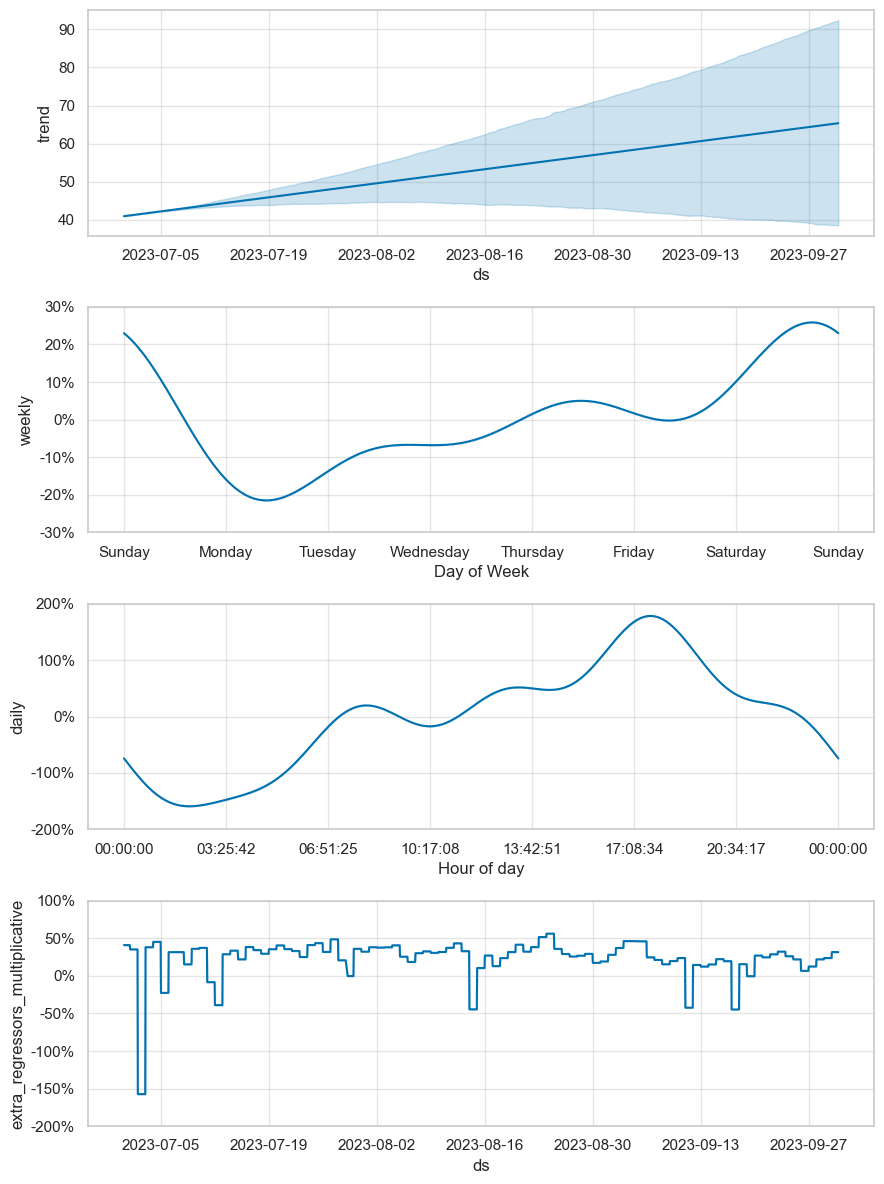

In [116]:
# Predicting using the model
m.fit(train8_start_prophet)
future   = test8_start_prophet.copy()
forecast = m.predict(future)
fig = m.plot_components(forecast)

In [117]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Prepare data for LightGBM
train_lgb = train8_start_prophet.copy()
test_lgb = test8_start_prophet.copy()

# Add Prophet predictions as a feature
train_lgb['prophet_yhat'] = m.predict(train_lgb)['yhat']
test_lgb['prophet_yhat'] = forecast['yhat']

# LightGBM model
features = ['temp', 'precip', 'snow', 'Gas Price', 'total_crimes', 'prophet_yhat']
target = 'y'

# Create LightGBM datasets
lgb_train = lgb.Dataset(train_lgb[features], train_lgb[target])
lgb_eval = lgb.Dataset(test_lgb[features], test_lgb[target], reference=lgb_train)

# LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# Train LightGBM model
gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_eval])

# Make predictions
y_pred = gbm.predict(test_lgb[features], num_iteration=gbm.best_iteration)

# Evaluate the model
rmse = mean_squared_error(test_lgb[target], y_pred, squared=False)
print(f'RMSE: {rmse}')


RMSE: 29.71581431549771


In [118]:
# Combine Prophet and LightGBM predictions
combined_forecast = 0.5 * forecast['yhat'] + 0.5 * y_pred

# Evaluate the combined model
combined_rmse = mean_squared_error(test_lgb[target], combined_forecast, squared=False)
print(f'Combined RMSE: {combined_rmse}')

Combined RMSE: 29.571719558598


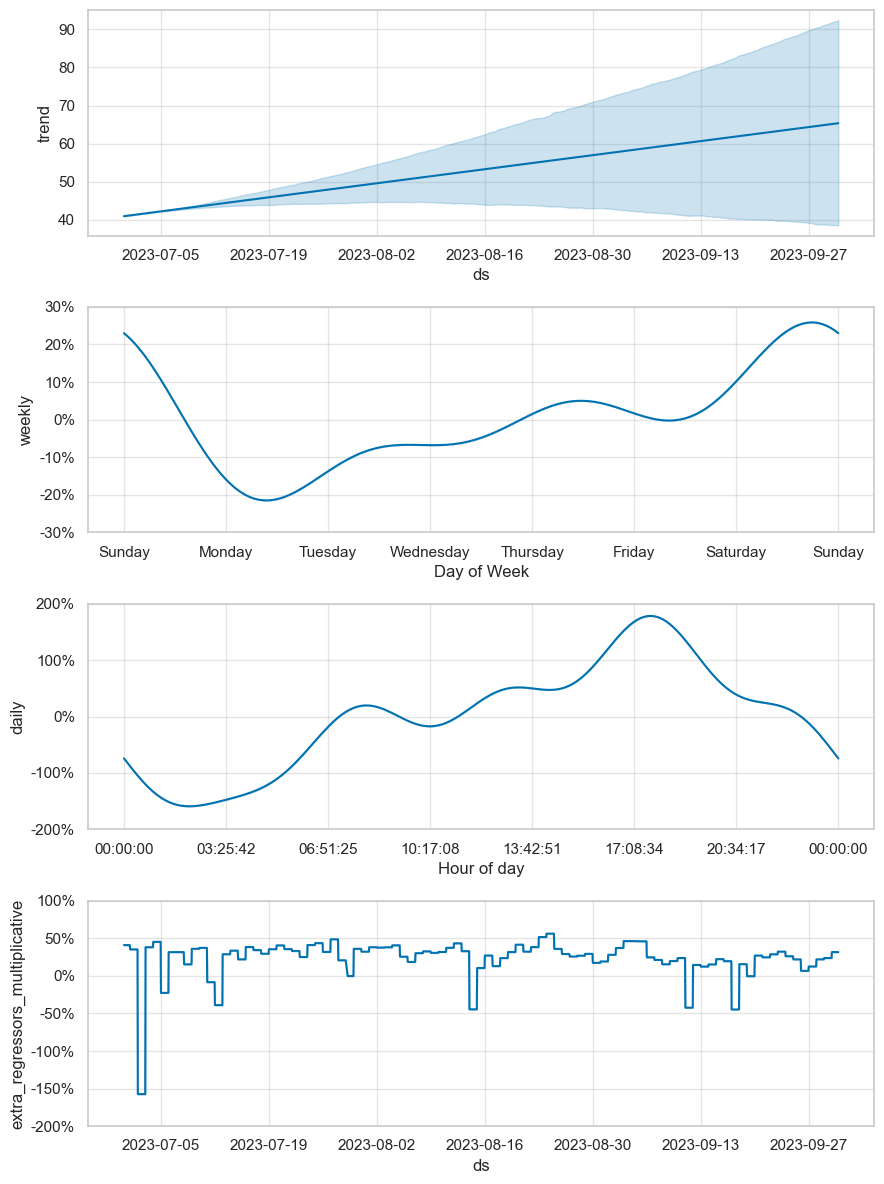

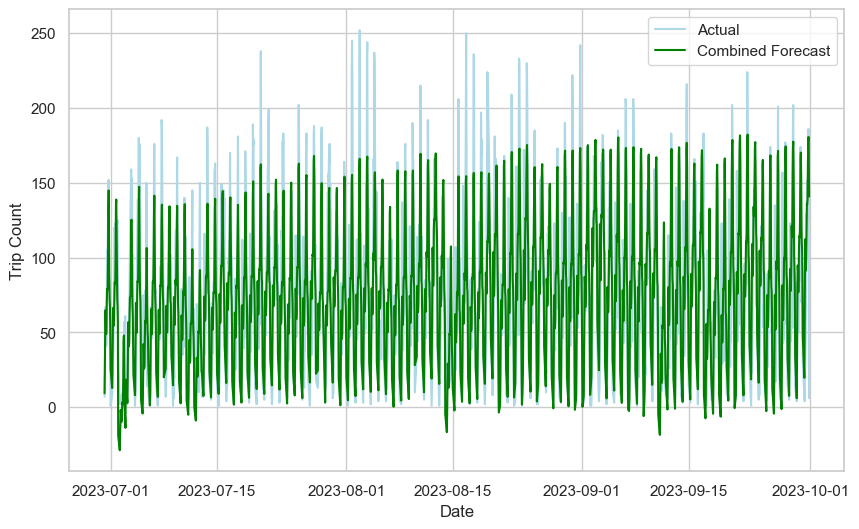

In [119]:
import matplotlib.pyplot as plt

# Plot Prophet components
fig = m.plot_components(forecast)

# Plot combined predictions
plt.figure(figsize=(10, 6))
plt.plot(test_lgb['ds'], test_lgb[target], label='Actual', color = 'lightblue')
plt.plot(test_lgb['ds'], combined_forecast, label='Combined Forecast', color = 'Green')
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.legend()
plt.show()

The RMSE is 29.57 for Prophet +LighGBM ensemble. For Prophet alone it is 30.56. Feels like it is not worth the GPU load.

### Combining all communities for Predicting Start count -Prophet ###

In [120]:
# Initialize lists to store results
results = []
prophet_forecast_df = pd.DataFrame()

# Loop through all 77 communities
for community in range(1, 78):
    # Filter data for the current community
    train_startdemand = train_data[train_data['Start Community Area Number'] == community]
    test_startdemand = test_data[test_data['Start Community Area Number'] == community]
    
    # Preparing the train data for Prophet
    train_prophet = train_startdemand.reset_index()
    train_prophet = train_prophet[['trip_start', 'trip_count', 'temp', 'precip', 'snow', 'Gas Price', 'total_crimes']].reset_index(drop=True)
    train_prophet = train_prophet.rename(columns={'trip_start': 'ds', 'trip_count': 'y'})
    
    # Preparing the test data for Prophet
    test_prophet = test_startdemand.reset_index()
    test_prophet = test_prophet[['trip_start', 'trip_count', 'temp', 'precip', 'snow', 'Gas Price', 'total_crimes']].reset_index(drop=True)
    test_prophet = test_prophet.rename(columns={'trip_start': 'ds', 'trip_count': 'y'})
    
    # Modeling
    m = Prophet(weekly_seasonality=True, yearly_seasonality='auto', seasonality_mode='multiplicative', seasonality_prior_scale=10)
    m.add_seasonality(name='daily', period=1, fourier_order=5)
    m.add_regressor('temp')
    m.add_regressor('precip')
    m.add_regressor('snow')
    m.add_regressor('Gas Price')
    m.add_regressor('total_crimes')
    
    # Fit the model
    m.fit(train_prophet)
    
    # Predict using the model
    future = test_prophet.copy()
    forecast = m.predict(future)
    
    # Create the predicted DataFrame
    prophet_df = pd.DataFrame({
        'Community': community,
        'trip_start': forecast['ds'].values,
        'Predicted_start_count': forecast['yhat'].values,
        'Actual_count': test_prophet['y'].values
    })
    
    # Set negative predictions to zero
    prophet_df['Predicted_start_count'] = prophet_df['Predicted_start_count'].apply(lambda x: max(0, x))
    
    # Concatenate the forecast DataFrame for each community
    prophet_forecast_df = pd.concat([prophet_forecast_df, prophet_df], ignore_index=True)
    
    # Calculate evaluation metrics
    prophet_mse = mean_squared_error(prophet_df['Actual_count'], prophet_df['Predicted_start_count'])
    prophet_mae = mean_absolute_error(prophet_df['Actual_count'], prophet_df['Predicted_start_count'])
    prophet_mape = mean_absolute_percentage_error(prophet_df['Actual_count'], prophet_df['Predicted_start_count'])
    
    # Store results
    results.append({
        'Community': community,
        'MSE': prophet_mse,
        'MAE': prophet_mae,
        'MAPE': prophet_mape
    })
    
    #prophet_forecast_df.append({prophet_df})
    # Print results for each community (optional)
    #print(f'Community {community} - Mean Squared Error: {prophet_mse}')
    #print(f'Community {community} - Mean Absolute Error: {prophet_mae}')

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)


20:35:38 - cmdstanpy - INFO - Chain [1] start processing
20:35:38 - cmdstanpy - INFO - Chain [1] done processing
20:35:38 - cmdstanpy - INFO - Chain [1] start processing
20:35:39 - cmdstanpy - INFO - Chain [1] done processing
20:35:39 - cmdstanpy - INFO - Chain [1] start processing
20:35:40 - cmdstanpy - INFO - Chain [1] done processing
20:35:40 - cmdstanpy - INFO - Chain [1] start processing
20:35:40 - cmdstanpy - INFO - Chain [1] done processing
20:35:41 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing
20:35:42 - cmdstanpy - INFO - Chain [1] start processing
20:35:43 - cmdstanpy - INFO - Chain [1] done processing
20:35:43 - cmdstanpy - INFO - Chain [1] start processing
20:35:44 - cmdstanpy - INFO - Chain [1] done processing
20:35:45 - cmdstanpy - INFO - Chain [1] start processing
20:35:47 - cmdstanpy - INFO - Chain [1] done processing
20:35:47 - cmdstanpy - INFO - Chain [1] start processing
20:35:47 - cmdstanpy - INFO - Chain [1]

20:36:30 - cmdstanpy - INFO - Chain [1] done processing
20:36:30 - cmdstanpy - INFO - Chain [1] start processing
20:36:30 - cmdstanpy - INFO - Chain [1] done processing
20:36:30 - cmdstanpy - INFO - Chain [1] start processing
20:36:30 - cmdstanpy - INFO - Chain [1] done processing
20:36:31 - cmdstanpy - INFO - Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] done processing
20:36:31 - cmdstanpy - INFO - Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
# MSE for each community
results_df

,Community,MSE,MAE,MAPE
0,1,30.275914,4.354343,0.683021
1,2,18.636319,3.323230,0.682919
2,3,103.902208,7.966530,0.862332
3,4,20.208652,3.555014,0.835083
4,5,42.264685,4.927855,0.914078
...,...,...,...,...
72,73,3.407270,1.349894,0.600603
73,74,0.724676,0.553951,0.333106
74,75,1.104745,0.794537,0.551613
75,76,1.068828,0.780472,0.633380


In [122]:
# Finding the Average community
average_MSE = results_df['MSE'].mean()
average_MAE = results_df['MAE'].mean()
average_MAPE = results_df['MAPE'].mean()

print(f'Average Mean Squared Error: {average_MSE}')
print(f'Average Mean Absolute Error: {average_MAE}')
print(f'Average Mean Absolute Percentage Error: {average_MAPE}')

Average Mean Squared Error: 73.9733053181253
Average Mean Absolute Error: 3.888539020054196
Average Mean Absolute Percentage Error: 0.6772672179712433


In [123]:
# Forecasts
prophet_forecast_df.head(60)

,Community,trip_start,Predicted_start_count,Actual_count
0,1,2023-06-30 05:00:00,1.492547,2
1,1,2023-06-30 06:00:00,5.890591,1
2,1,2023-06-30 07:00:00,8.545409,4
3,1,2023-06-30 08:00:00,9.771589,14
4,1,2023-06-30 09:00:00,10.042726,9
5,1,2023-06-30 10:00:00,9.994156,9
6,1,2023-06-30 11:00:00,10.572662,8
7,1,2023-06-30 12:00:00,12.321950,15
8,1,2023-06-30 13:00:00,14.641627,7
9,1,2023-06-30 14:00:00,16.398045,18


### Combining all communities for Predicting End count ###

#### Train-Test Split for End Demand ####

In [124]:
# Sort data by time
end_demand.sort_values('trip_end', inplace=True)

# Define the split date
# Train = May 10, 2022 to June 30, 2023
# Test = July 1, 2023 to Sept 29, 2023
end_train_date = '2023-06-30' 

# Split the data
end_train_data = end_demand[end_demand['trip_end'] <= end_train_date]
end_test_data = end_demand[end_demand['trip_end'] > end_train_date]

#train_data.to_csv('train_hourly_demand.csv', index=False)
#test_data.to_csv('test_hourly_demand.csv', index=False)

# Printing sizes
print(f"Training set size for End Demand: {len(end_train_data)}")
print(f"Test set size for End Demand: {len(end_test_data)}")

Training set size for End Demand: 299432
Test set size for End Demand: 108603


### Modeling with Prophet for End Demand Prediction ###

In [125]:
# Initialize lists to store results
end_results = []
end_prophet_forecast_df = pd.DataFrame()

# Loop through all 77 communities
for community in range(1, 78):
    # Filter data for the current community
    end_train_demand = end_train_data[end_train_data['End Community Area Number'] == community]
    end_test_demand = end_test_data[end_test_data['End Community Area Number'] == community]
    
    # Preparing the train data for Prophet
    end_train_prophet = end_train_demand.reset_index()
    end_train_prophet = end_train_prophet[['trip_end', 'trip_count', 'temp', 'precip', 'snow', 'Gas Price', 'total_crimes']].reset_index(drop=True)
    end_train_prophet = end_train_prophet.rename(columns={'trip_end': 'ds', 'trip_count': 'y'})
    
    # Preparing the test data for Prophet
    end_test_prophet = end_test_demand.reset_index()
    end_test_prophet = end_test_prophet[['trip_end', 'trip_count', 'temp', 'precip', 'snow', 'Gas Price', 'total_crimes']].reset_index(drop=True)
    end_test_prophet = end_test_prophet.rename(columns={'trip_end': 'ds', 'trip_count': 'y'})
    
    # Modeling
    m1 = Prophet(weekly_seasonality=True, yearly_seasonality='auto', seasonality_mode='multiplicative', seasonality_prior_scale=10)
    m1.add_seasonality(name='daily', period=1, fourier_order=5)
    m1.add_regressor('temp')
    m1.add_regressor('precip')
    m1.add_regressor('snow')
    m1.add_regressor('Gas Price')
    m1.add_regressor('total_crimes')
    
    # Fit the model
    m1.fit(end_train_prophet)
    
    # Predict using the model
    future1 = end_test_prophet.copy()
    forecast1 = m1.predict(future1)
    
    # Create the predicted DataFrame
    end_prophet_df = pd.DataFrame({
        'Community': community,
        'trip_end': forecast1['ds'].values,
        'Predicted_end_count': forecast1['yhat'].values,
        'Actual_count': end_test_prophet['y'].values
    })
    
    # Set negative predictions to zero
    end_prophet_df['Predicted_end_count'] = end_prophet_df['Predicted_end_count'].apply(lambda x: max(0, x))
    
    # Concatenate the forecast DataFrame for each community
    end_prophet_forecast_df = pd.concat([end_prophet_forecast_df, end_prophet_df], ignore_index=True)
    
    # Calculate evaluation metrics
    end_prophet_mse = mean_squared_error(end_prophet_df['Actual_count'], end_prophet_df['Predicted_end_count'])
    end_prophet_mae = mean_absolute_error(end_prophet_df['Actual_count'], end_prophet_df['Predicted_end_count'])
    
    # Store results
    end_results.append({
        'Community': community,
        'MSE': end_prophet_mse,
        'MAE': end_prophet_mae   
    })
    
    #prophet_forecast_df.append({prophet_df})
    # Print results for each community (optional)
    #print(f'Community {community} - Mean Squared Error: {prophet_mse}')
    #print(f'Community {community} - Mean Absolute Error: {prophet_mae}')

# Convert results to a DataFrame for easier analysis
end_results_df = pd.DataFrame(end_results)


20:36:32 - cmdstanpy - INFO - Chain [1] start processing
20:36:32 - cmdstanpy - INFO - Chain [1] done processing
20:36:33 - cmdstanpy - INFO - Chain [1] start processing
20:36:33 - cmdstanpy - INFO - Chain [1] done processing
20:36:33 - cmdstanpy - INFO - Chain [1] start processing
20:36:34 - cmdstanpy - INFO - Chain [1] done processing
20:36:34 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing
20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:36 - cmdstanpy - INFO - Chain [1] done processing
20:36:36 - cmdstanpy - INFO - Chain [1] start processing
20:36:37 - cmdstanpy - INFO - Chain [1] done processing
20:36:38 - cmdstanpy - INFO - Chain [1] start processing
20:36:38 - cmdstanpy - INFO - Chain [1] done processing
20:36:39 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing
20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:41 - cmdstanpy - INFO - Chain [1]

20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
end_results_df

,Community,MSE,MAE
0,1,28.078281,4.195421
1,2,18.828765,3.352651
2,3,114.193514,8.395549
3,4,19.671389,3.506855
4,5,42.203680,5.014100
...,...,...,...
72,73,3.570244,1.352929
73,74,0.457140,0.448060
74,75,0.986549,0.744041
75,76,0.758667,0.582857


In [127]:
# Finding the Average community
end_average_MSE = end_results_df['MSE'].mean()
end_average_MAE = end_results_df['MAE'].mean()
print(f'Average Mean Squared Error for End Trips: {end_average_MSE}')
print(f'Average Mean Absolute Error for End Trips: {end_average_MAE}')

Average Mean Squared Error for End Trips: 66.85262369708137
Average Mean Absolute Error for End Trips: 3.766624626598924


In [128]:
# Forecasts
#pd.set_option('display.max_rows', None)
end_prophet_forecast_df

,Community,trip_end,Predicted_end_count,Actual_count
0,1,2023-06-30 07:00:00,7.230755,2
1,1,2023-06-30 08:00:00,8.344960,6
2,1,2023-06-30 09:00:00,8.941800,5
3,1,2023-06-30 10:00:00,9.406491,12
4,1,2023-06-30 11:00:00,10.060604,8
...,...,...,...,...
108598,77,2023-09-30 16:00:00,32.654937,23
108599,77,2023-09-30 17:00:00,34.117108,30
108600,77,2023-09-30 18:00:00,34.018515,25
108601,77,2023-09-30 19:00:00,31.742420,29


#### Joining Trip start counts and Trip end counts ####

In [129]:
# Ensure trip_start is in datetime format
prophet_forecast_df['trip_start'] = pd.to_datetime(prophet_forecast_df['trip_start'])


# Convert trip_end to datetime
end_prophet_forecast_df['trip_end'] = pd.to_datetime(end_prophet_forecast_df['trip_end'])

# Merge the DataFrames on Community and the respective datetime columns
both_merged = pd.merge(
    prophet_forecast_df,
    end_prophet_forecast_df,
    how = 'left',
    left_on=['Community', 'trip_start'],
    right_on=['Community', 'trip_end']
)


# Drop the 'Date' and 'Trip Week Start' columns as they are no longer needed
both_merged_df = both_merged.drop(columns=['Actual_count_x','Actual_count_y'])

In [130]:
# Cleaning the both_merged_df

# Fill NaT values in 'trip_end' with the corresponding 'trip_start' values
both_merged_df['trip_end'] = both_merged_df['trip_end'].fillna(both_merged_df['trip_start'])

# Fill NaN values in 'Predicted_end_count' with 0
both_merged_df['Predicted_end_count'] = both_merged_df['Predicted_end_count'].fillna(0)

both_merged_df['Predicted_start_count'] = both_merged_df['Predicted_start_count'].round().astype(int)
both_merged_df['Predicted_end_count'] = both_merged_df['Predicted_end_count'].round().astype(int)

demand_prediction  = both_merged_df.copy()


### Checking the Variance for a month of data ###

In [131]:
# Copying both_merged dataframe
both_merged1_df = both_merged.copy()

# Fill NaT values in 'trip_end' with the corresponding 'trip_start' values
both_merged1_df['trip_end'] = both_merged1_df['trip_end'].fillna(both_merged1_df['trip_start'])

# Fill NaN values in 'Predicted_end_count' with 0
both_merged1_df['Predicted_end_count'] = both_merged1_df['Predicted_end_count'].fillna(0)


both_merged1_df['Predicted_start_count'] = both_merged1_df['Predicted_start_count'].round().astype(int)
both_merged1_df['Predicted_end_count'] = both_merged1_df['Predicted_end_count'].round().astype(int)

# Rename columns using direct assignment
both_merged1_df.columns = ['Community', 'trip_start', 'Predicted_start_count', 'Actual_start_count', 'trip_end',
              'Predicted_end_count', 'Actual_end_count']
both_merged1_df['Actual_end_count'] = both_merged1_df['Actual_end_count'].fillna(0)

both_merged1_df

,Community,trip_start,Predicted_start_count,Actual_start_count,trip_end,Predicted_end_count,Actual_end_count
0,1,2023-06-30 05:00:00,1,2,2023-06-30 05:00:00,0,0.0
1,1,2023-06-30 06:00:00,6,1,2023-06-30 06:00:00,0,0.0
2,1,2023-06-30 07:00:00,9,4,2023-06-30 07:00:00,7,2.0
3,1,2023-06-30 08:00:00,10,14,2023-06-30 08:00:00,8,6.0
4,1,2023-06-30 09:00:00,10,9,2023-06-30 09:00:00,9,5.0
...,...,...,...,...,...,...,...
106830,77,2023-09-30 16:00:00,33,24,2023-09-30 16:00:00,33,23.0
106831,77,2023-09-30 17:00:00,34,27,2023-09-30 17:00:00,34,30.0
106832,77,2023-09-30 18:00:00,33,19,2023-09-30 18:00:00,34,25.0
106833,77,2023-09-30 19:00:00,30,26,2023-09-30 19:00:00,32,29.0


In [132]:
# Write the DataFrame to a CSV file
both_merged1_df.to_csv('both_merged1_df.csv', index=False)

In [133]:
# Convert trip_start to datetime
both_merged1_df['trip_start'] = pd.to_datetime(both_merged1_df['trip_start'])

# Extract month and year for aggregation
#both_merged1_df['month_year'] = both_merged1_df['trip_start'].dt.to_period('M')

# Filter data for August
august_data = both_merged1_df[both_merged1_df['trip_start'].dt.month == 8]

# Group by Community and month, then aggregate counts
agg_august = august_data.agg({
    'Predicted_start_count': 'sum',
    'Predicted_end_count': 'sum',
    'Actual_start_count': 'sum',
    'Actual_end_count': 'sum'
}).reset_index()
agg_august.columns = ['Metrics', 'Values']
agg_august

,Metrics,Values
0,Predicted_start_count,485209.0
1,Predicted_end_count,475088.0
2,Actual_start_count,505040.0
3,Actual_end_count,499745.0


In [134]:
# Variance in start count for the month August
var_start_count = agg_august.iloc[2,1] - agg_august.iloc[0,1]
print(f'The Difference of Start count for the month August: ',var_start_count)

# Variance in end count for the month August
var_end_count = agg_august.iloc[3,1] - agg_august.iloc[1,1]
print(f'The Difference of End count for the month August: ',var_end_count)

The Difference of Start count for the month August:  19831.0
The Difference of End count for the month August:  24657.0


In [135]:
both_merged1_df[both_merged1_df['Predicted_start_count']< both_merged1_df['Actual_start_count']].count()
40679/106835

0.38076473065942806

#### Difference in count by Community ####

In [136]:
# Group by Community and month, then aggregate counts
agg_august_by_community = august_data.groupby('Community').agg({
    'Predicted_start_count': 'sum',
    'Predicted_end_count': 'sum',
    'Actual_start_count': 'sum',
    'Actual_end_count': 'sum'
}).reset_index()
#agg_august.columns = ['Metrics', 'Values']
agg_august_by_community

,Community,Predicted_start_count,Predicted_end_count,Actual_start_count,Actual_end_count
0,1,9086,8690,7843,7837.0
1,2,5422,5780,5358,5493.0
2,3,14958,15166,12061,11836.0
3,4,6131,6002,5282,5348.0
4,5,8327,8248,7437,7585.0
...,...,...,...,...,...
72,73,1298,1154,1425,1379.0
73,74,4,3,7,3.0
74,75,351,232,289,220.0
75,76,88,47,58,39.0


In [137]:
#pd.options.display.max_rows = None

# Subtract predicted from actual for both start and end counts
agg_august_by_community['Start_count_diff'] = agg_august_by_community['Actual_start_count'] - agg_august_by_community['Predicted_start_count']
agg_august_by_community['End_count_diff'] = agg_august_by_community['Actual_end_count'] - agg_august_by_community['Predicted_end_count']
agg_august_by_community.head(77)

,Community,Predicted_start_count,Predicted_end_count,Actual_start_count,Actual_end_count,Start_count_diff,End_count_diff
0,1,9086,8690,7843,7837.0,-1243,-853.0
1,2,5422,5780,5358,5493.0,-64,-287.0
2,3,14958,15166,12061,11836.0,-2897,-3330.0
3,4,6131,6002,5282,5348.0,-849,-654.0
4,5,8327,8248,7437,7585.0,-890,-663.0
...,...,...,...,...,...,...,...
72,73,1298,1154,1425,1379.0,127,225.0
73,74,4,3,7,3.0,3,0.0
74,75,351,232,289,220.0,-62,-12.0
75,76,88,47,58,39.0,-30,-8.0


### Revenue Calculation ###

In [138]:
revenue_projection = both_merged1_df.copy()
revenue_projection['Predicted_start_count'] += 1
revenue_projection

,Community,trip_start,Predicted_start_count,Actual_start_count,trip_end,Predicted_end_count,Actual_end_count
0,1,2023-06-30 05:00:00,2,2,2023-06-30 05:00:00,0,0.0
1,1,2023-06-30 06:00:00,7,1,2023-06-30 06:00:00,0,0.0
2,1,2023-06-30 07:00:00,10,4,2023-06-30 07:00:00,7,2.0
3,1,2023-06-30 08:00:00,11,14,2023-06-30 08:00:00,8,6.0
4,1,2023-06-30 09:00:00,11,9,2023-06-30 09:00:00,9,5.0
...,...,...,...,...,...,...,...
106830,77,2023-09-30 16:00:00,34,24,2023-09-30 16:00:00,33,23.0
106831,77,2023-09-30 17:00:00,35,27,2023-09-30 17:00:00,34,30.0
106832,77,2023-09-30 18:00:00,34,19,2023-09-30 18:00:00,34,25.0
106833,77,2023-09-30 19:00:00,31,26,2023-09-30 19:00:00,32,29.0


In [139]:
revenue_projection_community = revenue_projection.groupby('Community').agg({
    'Predicted_start_count': 'sum',
    'Actual_start_count': 'sum',
    'Predicted_end_count': 'sum',
    'Actual_end_count': 'sum'
}).reset_index()
revenue_projection_community

,Community,Predicted_start_count,Actual_start_count,Predicted_end_count,Actual_end_count
0,1,27738,23163,24764,22888.0
1,2,17240,15458,16689,16094.0
2,3,46530,33904,45442,33237.0
3,4,19495,15421,17419,15646.0
4,5,25638,20241,23729,20619.0
...,...,...,...,...,...
72,73,5150,4199,3288,3993.0
73,74,68,48,22,34.0
74,75,1727,1019,775,802.0
75,76,448,218,168,160.0


In [140]:
#pd.set_option('display.max_rows', None)
#Calculating revenue for predicted and Actual
revenue_community = revenue_projection_community.copy()
revenue_community['Predicted_revenue'] = revenue_community['Predicted_start_count']*8
revenue_community['Actual_revenue'] = revenue_community['Actual_start_count']*8
revenue_community

,Community,Predicted_start_count,Actual_start_count,Predicted_end_count,Actual_end_count,Predicted_revenue,Actual_revenue
0,1,27738,23163,24764,22888.0,221904,185304
1,2,17240,15458,16689,16094.0,137920,123664
2,3,46530,33904,45442,33237.0,372240,271232
3,4,19495,15421,17419,15646.0,155960,123368
4,5,25638,20241,23729,20619.0,205104,161928
...,...,...,...,...,...,...,...
72,73,5150,4199,3288,3993.0,41200,33592
73,74,68,48,22,34.0,544,384
74,75,1727,1019,775,802.0,13816,8152
75,76,448,218,168,160.0,3584,1744


In [141]:
#Maximum and minimum revenue community
max_revenue_community = revenue_community.loc[revenue_community['Predicted_revenue'].idxmax()]['Community']
min_revenue_community = revenue_community.loc[revenue_community['Predicted_revenue'].idxmin()]['Community']
print("Community with Maximum Predicted Revenue: ", max_revenue_community)
print("Community with Minimum Predicted Revenue: ", min_revenue_community)

Community with Maximum Predicted Revenue:  8.0
Community with Minimum Predicted Revenue:  74.0


In [142]:
total_predicted_rev = revenue_community['Predicted_revenue'].sum()
total_actual_rev = revenue_community['Actual_revenue'].sum()
print("Total Predicted Revenue: ", total_predicted_rev)
print("Total actual Revenue: ", total_actual_rev)

Total Predicted Revenue:  12045096
Total actual Revenue:  11414312


In [143]:
(12045096-11414312)/11414312

0.05526255108498874

### Supply & Demand Calculation ###

The demand logic derived from Supply is as follows.
1. A low supply threshold is calculated as the 1st quantile of the scooter supply for a community. If the scooter supply is less than low supply threshold, a demand is anticipated and 1 is added to the unmet_demand_index.
2. If the net_count_delta in the supply calculation is less than or equal to zero that denotes there is no scooters to start with in that hour of time. Also, if the abs(net_count_delta) is greater than scooter supply there is no replenishment in order. Hence a demand is anticipated and 1 is added to the unmet_demand_index.
3. If a Predicted start count is greater than the supply, there is a demand and hence 1 is added to the unmet_demand_index.

We are finding the unmet demand index calculated through a pattern check as per below logic. The demand index value ranges from 1- 6. The more the demand index the more certainity for a demand. Here for the pattern check to be triggered, the unmet_demand_index calculated from the supply formulation steps should be greater than 0. In other words, pattern check will be triggered only if the supply index is atleast 1.

5 Cases are dealt here for deriving the demand index:

1. A low availability threshold is calculated per community as the 5th percentile of Predicted start count. If the start count at a community area is less than this low availability threshold, a demand is anticipated and unmet demand index is added with a 1.

2. The weekend threshold was calculated just like low availability threshold. Weekend threshold was divided to peak hours and other hours and then found the threshold for each by taking the mean of start counts. If a Predicted start count for a weekend is less than expected average start count, a demand is noted and 1 is added to unmet demand index.

3. Similarly a peak hour threshold is calculated for each community for other days as the average value of start counts for peak hours. If for an hour in a community, the start count is less than this peak hour threshold value, a demand is anticipated and 1 is added to unmet demand index. (Instead of average we can consider 80th percentile or so)

4. **The net_demand = number of end trips - number of start trips** 
   A continuous positive net_demand for past three records assumes a demand in that community area. Hence 1 is added to unmet demand index.
   
5. A positive net_demand for past 3 days for the same hour in the community area is anticipated as a demand for that hour in that community area. Hence 1 is added to unmet demand index.

In [144]:
# Initialize the e-scooter count
net_counter_df = both_merged_df.copy()
net_counter_df['net_count'] = 0
net_counter_df['net_count_delta'] = 0

# Get the list of unique communities
communities = net_counter_df['Community'].unique()

# Saving the baseline values and last supply_counts
baseline_value_storage = [0] * len(communities)
supply_checkpoint = [0] * len(communities)

# Initialize the DataFrame for index_flags
index_flags = pd.DataFrame({
    'Community': range(1, 78),  # Community numbers from 1 to 77
    'zero_carryover': [0] * 77,
    'low_supply_flag': [0] * 77,
    'unmet_demand_flag': [0] * 77
})

# Process the data for each community
for community in communities:
    community_df = net_counter_df[net_counter_df['Community'] == community].copy()
    
    # Set the first instance of net_count to the negative value of the start_count
    community_df.loc[community_df.index[0], 'net_count'] = -community_df.loc[community_df.index[0], 'Predicted_start_count']
    
    for i in range(1, len(community_df)):
        community_df.loc[community_df.index[i], 'net_count'] = (
            community_df.loc[community_df.index[i-1], 'net_count']
            - community_df.loc[community_df.index[i], 'Predicted_start_count']
            + community_df.loc[community_df.index[i-1], 'Predicted_end_count']
        )

    for i in range(1, len(community_df)):
        community_df.loc[community_df.index[i], 'net_count_delta'] = (
            - community_df.loc[community_df.index[i], 'Predicted_start_count']
            + community_df.loc[community_df.index[i-1], 'Predicted_end_count']
        )

    
    # Determine the minimum net_count value for the current community
    baseline_supply = abs(community_df['net_count'].min())

    # Add 'scooter_supply' column for the current community
    community_df['scooter_supply'] = community_df['net_count'] + baseline_supply

    # Saving carryover values for forecast calculations
    community_index = community - 1
    baseline_value_storage[community_index] = baseline_supply
    supply_checkpoint[community_index] = community_df['scooter_supply'].iloc[-1]
    
    if supply_checkpoint[community_index] == 0:
        index_flags.loc[community_index, 'zero_carryover'] = 1
        
    supply_checkpoint[community_index] = community_df['scooter_supply'].iloc[-1] + community_df['Predicted_end_count'].iloc[-1]
    
    # Update the main DataFrame
    net_counter_df.loc[net_counter_df['Community'] == community, 'scooter_supply'] = community_df['scooter_supply']
    net_counter_df.loc[net_counter_df['Community'] == community, 'net_count'] = community_df['net_count']
    net_counter_df.loc[net_counter_df['Community'] == community, 'net_count_delta'] = community_df['net_count_delta']

In [145]:
net_counter_df

,Community,trip_start,Predicted_start_count,trip_end,Predicted_end_count,net_count,net_count_delta,scooter_supply
0,1,2023-06-30 05:00:00,1,2023-06-30 05:00:00,0,-1,0,1200.0
1,1,2023-06-30 06:00:00,6,2023-06-30 06:00:00,0,-7,-6,1194.0
2,1,2023-06-30 07:00:00,9,2023-06-30 07:00:00,7,-16,-9,1185.0
3,1,2023-06-30 08:00:00,10,2023-06-30 08:00:00,8,-19,-3,1182.0
4,1,2023-06-30 09:00:00,10,2023-06-30 09:00:00,9,-21,-2,1180.0
...,...,...,...,...,...,...,...,...
106830,77,2023-09-30 16:00:00,33,2023-09-30 16:00:00,33,269,-2,334.0
106831,77,2023-09-30 17:00:00,34,2023-09-30 17:00:00,34,268,-1,333.0
106832,77,2023-09-30 18:00:00,33,2023-09-30 18:00:00,34,269,1,334.0
106833,77,2023-09-30 19:00:00,30,2023-09-30 19:00:00,32,273,4,338.0


In [146]:
# Demand Supply logic
supply_indexing_df = net_counter_df.copy()
# Initialize columns
supply_indexing_df['supply_index'] = 0
supply_indexing_df['net_demand'] = 0
supply_indexing_df['unmet_demand_index'] = 0
supply_indexing_df['net_demand'] = 0
supply_indexing_df['demand_flag'] = 'NA'


# Define additional thresholds for other scenarios
peak_hours = [15, 16, 17, 18, 19, 20, 21, 22]# peak hours
other_hours = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23, 0]
weekend_days = [4, 5, 6]  #(Friday, Saturday, Sunday)


# Function to calculate supply index
def calculate_demand_supply_index(df):
    # Process the data for each community
    for community in df['Community'].unique():
        community_df = df[df['Community'] == community].copy()
        baseline_value = community_df['scooter_supply'].max()
        # Calculate low supply threshold (10th percentile)
        if baseline_value < 700:
            low_supply_threshold = 50
        else:
            low_supply_threshold = round(community_df['scooter_supply'].quantile(0.01))
        
        # Calculate low availability threshold (5th percentile)
        low_availability_threshold = round(community_df['Predicted_start_count'].quantile(0.05))
        
        # Calculate peak hour threshold (average start count during peak hours)
        peak_hour_data = community_df[community_df['trip_start'].dt.hour.isin(peak_hours)]
        peak_hour_threshold = peak_hour_data['Predicted_start_count'].mean()
        
        # Calculate peak hour threshold for weekends
        weekend_data = community_df[community_df['trip_start'].dt.weekday.isin(weekend_days)]
        weekend_peak_hour_data = weekend_data[weekend_data['trip_start'].dt.hour.isin(peak_hours)]
        weekend_peak_hour_threshold = weekend_peak_hour_data['Predicted_start_count'].mean()
        
        # Calculate other hour threshold for weekends
        weekend_other_hour_data = weekend_data[weekend_data['trip_start'].dt.hour.isin(other_hours)]
        weekend_other_hour_threshold = weekend_other_hour_data['Predicted_start_count'].mean()
        
        for i in range(len(community_df)):
            row = community_df.iloc[i]
            net_demand = row['Predicted_end_count'] - row['Predicted_start_count']
            community_supply_index = 0
            unmet_demand_index = 0
            demand_flag = 'NA'

            # We only consider cases when the supply counts are below the established threshold
            if row['scooter_supply'] < low_supply_threshold:
                community_supply_index += 1
                unmet_demand_index += 1
                demand_flag = '1'
            
                # Logic: If the net_count in the supply calculation is negative, we see depletion occurring while supply is already low.
                if row['net_count_delta'] <= 0 and abs(row['net_count_delta']) >= row['scooter_supply']:
                    community_supply_index += 1
                    unmet_demand_index += 1
                    demand_flag = demand_flag+'2'
            
                    # Logic: Low supply + supply depletion + predicted trips (demand) for that interval exceed currently available supply
                    if row['Predicted_start_count'] > row['scooter_supply']:
                        community_supply_index += 1
                        unmet_demand_index += 1
                        demand_flag = demand_flag+'3'
            
            if unmet_demand_index > 0:
                
                # Pattern Logic 1: If the Predicted start count is less than low availability threshold
                if (row['Predicted_start_count'] < low_availability_threshold) and (row['Predicted_end_count'] > 0):
                    unmet_demand_index += 1
                    demand_flag = demand_flag+'4'
            
                # Pattern Logic 2: A Predicted start count for a weekend is less than expected average start count
                if row['trip_start'].weekday() in weekend_days:
                    if (row['trip_start'].hour in peak_hours) and (row['Predicted_start_count'] < weekend_peak_hour_threshold):
                        unmet_demand_index += 1
                        demand_flag = demand_flag+'5'
                    if row['trip_start'].hour in other_hours and row['Predicted_start_count'] < weekend_other_hour_threshold:
                        unmet_demand_index += 1
                        demand_flag = demand_flag+'5'
                else:
                    # Pattern Logic 3: If not weekend, and if the started trips in the peak hour is less than the peak_hour_threshold
                    if (row['trip_start'].hour in peak_hours) and (row['Predicted_start_count'] < peak_hour_threshold):
                        unmet_demand_index += 1
                        demand_flag = demand_flag+'5'
            
                # Pattern Logic 4: A Continuous positive net_demand
                if i > 2 and (community_df.iloc[i-1]['net_demand'] > 0) and (community_df.iloc[i-2]['net_demand'] > 0) and (community_df.iloc[i-2]['net_demand'] > 0):
                    unmet_demand_index += 1
                    demand_flag = demand_flag+'6'
            
                # Pattern Logic 5: Positive net_demand for past 3 days
                check_time = row['trip_start'].time()
                current_date = row['trip_start'].date()
                all_positive = True
                for days_back in range(1, 4):
                    past_date = current_date - pd.Timedelta(days=days_back)
                    past_record = community_df[(community_df['trip_start'].dt.date == past_date) & 
                                           (community_df['trip_start'].dt.time == check_time)]
                    if past_record.empty or past_record['net_demand'].values[0] <= 0:
                        all_positive = False
                        break
                if all_positive:
                    unmet_demand_index += 1
                    demand_flag = demand_flag+'7'
        
            community_df.at[community_df.index[i], 'supply_index'] = community_supply_index
            community_df.at[community_df.index[i], 'unmet_demand_index'] = unmet_demand_index
            community_df.at[community_df.index[i], 'demand_flag'] = demand_flag
            
        df.loc[df['Community'] == community, 'supply_index'] = community_df['supply_index']
        df.loc[df['Community'] == community, 'unmet_demand_index'] = community_df['unmet_demand_index']
        df.loc[df['Community'] == community, 'demand_flag'] = community_df['demand_flag']

        # Integrate into index_flags df
        community_index = community - 1
        index_flags.loc[community_index, 'low_supply_flag'] = community_supply_index
        index_flags.loc[community_index, 'unmet_demand_flag'] = unmet_demand_index

    return df

# Calculate signs of unmet demand
demand_supply_indexed_df = calculate_demand_supply_index(supply_indexing_df)

In [147]:
demand_supply_indexed_df[demand_supply_indexed_df['unmet_demand_index'] == 4]
# Filter rows where demand_index = 4 and supply_index = 3
filtered_df = demand_supply_indexed_df[(demand_supply_indexed_df['unmet_demand_index'] == 4) & (demand_supply_indexed_df['supply_index'] == 3)]

# Group by community and count occurrences
summary_df = filtered_df.groupby('Community').size().reset_index(name='count')
summary_df.sort_values(by = 'count', ascending = False)

,Community,count
5,14,4
0,2,2
10,33,2
8,27,2
9,31,2
4,13,2
6,16,1
7,20,1
3,11,1
1,3,1


In [148]:
pd.set_option('display.max_rows', None)
demand_supply_indexed_df[demand_supply_indexed_df['unmet_demand_index'] == 3]
# Filter rows where demand_index = 4 and supply_index = 3
filtered_df = demand_supply_indexed_df[(demand_supply_indexed_df['unmet_demand_index'] == 3) & (demand_supply_indexed_df['supply_index'] == 3)]

# Group by community and count occurrences
summary_df = filtered_df.groupby('Community').size().reset_index(name='count')
summary_df.sort_values(by = 'count', ascending = False)

,Community,count
62,66,8
43,45,8
24,25,7
33,35,7
54,58,7
70,75,6
9,10,6
32,34,6
64,68,6
61,65,5


**The more demand index, the more demand is anticipated**

In [149]:
# Write the DataFrame to a CSV file
demand_supply_indexed_df.to_csv('demand_supply.csv', index=False)

In [150]:
index_flags

,Community,zero_carryover,low_supply_flag,unmet_demand_flag
0,1,0,1,1
1,2,0,0,0
2,3,0,0,0
3,4,0,1,1
4,5,0,1,1
5,6,0,0,0
6,7,0,1,1
7,8,0,0,0
8,9,1,3,3
9,10,1,3,3


### Count of records that underwent each logic for Demand ###

In [151]:
# Count the records where demand_flag contains '1'
demand_logic1 = demand_supply_indexed_df['demand_flag'].str.contains('1').sum()
# Print the result
print(f'The number of records which underwent first logic: {demand_logic1}')

# Count the records where demand_flag contains '2'
demand_logic2 = demand_supply_indexed_df['demand_flag'].str.contains('2').sum()
# Print the result
print(f'The number of records which underwent second logic: {demand_logic2}')

# Count the records where demand_flag contains '3'
demand_logic3 = demand_supply_indexed_df['demand_flag'].str.contains('3').sum()
# Print the result
print(f'The number of records which underwent third logic: {demand_logic3}')

# Count the records where demand_flag contains '4'
demand_logic4 = demand_supply_indexed_df['demand_flag'].str.contains('4').sum()
# Print the result
print(f'The number of records which underwent fourth logic: {demand_logic4}')

# Count the records where demand_flag contains '5'
demand_logic5 = demand_supply_indexed_df['demand_flag'].str.contains('5').sum()
# Print the result
print(f'The number of records which underwent fifth logic: {demand_logic5}')

# Count the records where demand_flag contains '6'
demand_logic6 = demand_supply_indexed_df['demand_flag'].str.contains('6').sum()
# Print the result
print(f'The number of records which underwent sixth logic: {demand_logic6}')

# Count the records where demand_flag contains '7'
demand_logic7 = demand_supply_indexed_df['demand_flag'].str.contains('7').sum()
# Print the result
print(f'The number of records which underwent seventh logic: {demand_logic7}')


The number of records which underwent first logic: 18081
The number of records which underwent second logic: 303
The number of records which underwent third logic: 279
The number of records which underwent fourth logic: 198
The number of records which underwent fifth logic: 6101
The number of records which underwent sixth logic: 0
The number of records which underwent seventh logic: 0


### Forecast Predictions ###

### Future data for Weather ###

In [152]:
# Prophet requires columns 'ds' and 'y'
df_temp = df_weather[['datetime', 'temp']].rename(columns={'datetime': 'ds', 'temp': 'y'})

# Initialize and fit the model
model_temp = Prophet()
model_temp.fit(df_temp)

# Create a DataFrame for future dates (1 month ahead)
future_temp = model_temp.make_future_dataframe(periods=30)

# Make predictions
forecast_temp = model_temp.predict(future_temp)
forecast_temp[['ds', 'yhat']]

20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
0,2022-05-05,72.807886
1,2022-05-06,71.234365
2,2022-05-07,70.480888
3,2022-05-08,71.012978
4,2022-05-09,71.560995
5,2022-05-10,72.834964
6,2022-05-11,73.318333
7,2022-05-12,73.154157
8,2022-05-13,71.580636
9,2022-05-14,70.827159


In [153]:
df_weather

,datetime,temp,precip,snow,Weather Date
0,2022-05-05,49.7,0.188,0.0,2022-05-05
1,2022-05-06,51.1,0.367,0.0,2022-05-06
2,2022-05-07,55.9,0.000,0.0,2022-05-07
3,2022-05-08,58.3,0.000,0.0,2022-05-08
4,2022-05-09,70.8,0.000,0.0,2022-05-09
5,2022-05-10,80.3,0.000,0.0,2022-05-10
6,2022-05-11,82.4,0.000,0.0,2022-05-11
7,2022-05-12,84.4,0.000,0.0,2022-05-12
8,2022-05-13,81.8,0.000,0.0,2022-05-13
9,2022-05-14,76.7,0.000,0.0,2022-05-14


In [154]:
# For precipitation
df_precip = df_weather[['datetime', 'precip']].rename(columns={'datetime': 'ds', 'precip': 'y'})
model_precip = Prophet()
model_precip.fit(df_precip)
future_precip = model_precip.make_future_dataframe(periods=30)
forecast_precip = model_precip.predict(future_precip)
forecast_precip[['ds', 'yhat']]

20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
0,2022-05-05,0.061024
1,2022-05-06,0.058685
2,2022-05-07,0.080811
3,2022-05-08,0.152544
4,2022-05-09,0.081426
5,2022-05-10,0.101497
6,2022-05-11,0.120896
7,2022-05-12,0.060044
8,2022-05-13,0.057705
9,2022-05-14,0.079831


In [155]:
# For snow
df_snow = df_weather[['datetime', 'snow']].rename(columns={'datetime': 'ds', 'snow': 'y'})
model_snow = Prophet()
model_snow.fit(df_snow)
future_snow = model_snow.make_future_dataframe(periods=30)
forecast_snow = model_snow.predict(future_snow)
forecast_snow[['ds', 'yhat']]

20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
0,2022-05-05,-0.013345
1,2022-05-06,-0.007150
2,2022-05-07,-0.059063
3,2022-05-08,-0.068790
4,2022-05-09,-0.073477
5,2022-05-10,-0.106938
6,2022-05-11,-0.040378
7,2022-05-12,-0.007887
8,2022-05-13,-0.001692
9,2022-05-14,-0.053605


### Future Data for Gas Price ###

In [156]:
# For Gas Price
df_gasprice = df_gas[['Date', 'Gas Price']].rename(columns={'Date': 'ds', 'Gas Price': 'y'})
model_gasprice = Prophet()
model_gasprice.fit(df_gasprice)
future_gasprice = model_gasprice.make_future_dataframe(periods=4)
forecast_gasprice = model_gasprice.predict(future_gasprice)
forecast_gasprice[['ds', 'yhat']]
data_gas = {
    'Date': ['2023-10-09', '2023-10-16', '2023-10-23', '2023-10-30'],
    'Gas Price': [4.202883, 4.204753, 4.206623, 4.208494]
}

# Create DataFrame
data_gas_df = pd.DataFrame(data_gas)
data_gas_df

20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing


,Date,Gas Price
0,2023-10-09,4.202883
1,2023-10-16,4.204753
2,2023-10-23,4.206623
3,2023-10-30,4.208494


### Future Data for Crime dataset ###

In [157]:
# Reset display.max_rows to its default value (60)
pd.set_option('display.max_rows', 60)
# Extract the date part and create a new column 'Trip Date'
start_demand['Trip Date'] = start_demand['trip_start'].dt.date

# Create a new column 'Crime Date' in filtered_df_crimes
filtered_df_crimes['Crime Date'] = filtered_df_crimes['Date'].dt.date

# Group the filtered_df_crimes by 'Crime Date' and 'Community Area' and count the number of crimes
crime_counts = filtered_df_crimes.groupby(['Crime Date', 'Community Area']).size().reset_index(name='total_crimes')

# Merge the crime counts with escooter_df on 'Trip Date' and 'Start Community Area Number'
merged_df = pd.merge(start_demand, crime_counts,
                     left_on=['Trip Date', 'Start Community Area Number'],
                     right_on=['Crime Date', 'Community Area'],
                     how='left')

# Fill NaN values in 'total_crimes' with 0
merged_df['total_crimes'] = merged_df['total_crimes'].fillna(0)

# Drop the 'Crime Date' and 'Community Area' columns as they are no longer needed
start_demand = merged_df.drop(columns=['Crime Date', 'Community Area'])

KeyError: 'total_crimes'

In [ ]:
# Initialize lists to store results
results_october_forecast = []
prophet_october_df = pd.DataFrame()

# Loop through all 77 communities
for community in range(1, 78):
    # Filter data for the current community
    train_start_october = train_data[train_data['Start Community Area Number'] == community]
    test_start_october = test_data[test_data['Start Community Area Number'] == community]
    
    # Preparing the train data for Prophet
    train_prophet = train_start_october.reset_index()
    train_prophet = train_prophet[['trip_start', 'trip_count']].reset_index(drop=True)
    train_prophet = train_prophet.rename(columns={'trip_start': 'ds', 'trip_count': 'y'})
    
    # Preparing the test data for Prophet
    test_prophet = test_start_october.reset_index()
    test_prophet = test_prophet[['trip_start', 'trip_count']].reset_index(drop=True)
    test_prophet = test_prophet.rename(columns={'trip_start': 'ds', 'trip_count': 'y'})
    
    # Modeling
    m_o = Prophet(weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative', seasonality_prior_scale=10)
    m_o.add_seasonality(name='daily', period=1, fourier_order=5)
    #m.add_regressor('temp')
    #m.add_regressor('precip')
    #m.add_regressor('snow')
    #m.add_regressor('Gas Price')
    #m.add_regressor('total_crimes')
    
    # Fit the model
    m_o.fit(train_prophet)
    
    # Predict using the model
    future_o = m_o.make_future_dataframe(periods=3000, freq = 'H')
    forecast_o = m_o.predict(future_o)
    
    # Create the predicted DataFrame
    october_df = pd.DataFrame({
        'Community': community,
        'trip_start': forecast_o['ds'].values,
        'Predicted_start_count': forecast_o['yhat'].values
    })
    
    # Set negative predictions to zero
    october_df['Predicted_start_count'] = october_df['Predicted_start_count'].apply(lambda x: max(0, x))
    
    # Concatenate the forecast DataFrame for each community
    prophet_october_df = pd.concat([prophet_october_df, october_df], ignore_index=True)
    
    # Calculate evaluation metrics
#     prophet_mse = mean_squared_error(prophet_october_df['Actual_count'], prophet_october_df['Predicted_start_count'])
#     prophet_mae = mean_absolute_error(prophet_october_df['Actual_count'], prophet_october_df['Predicted_start_count'])
#     prophet_mape = mean_absolute_percentage_error(prophet_october_df['Actual_count'], prophet_october_df['Predicted_start_count'])
    
    # Store results
#     results_october_forecast.append({
#         'Community': community,
#         'MSE': prophet_mse,
#         'MAE': prophet_mae,
#         'MAPE': prophet_mape
#     })
    
    #prophet_forecast_df.append({prophet_df})
    # Print results for each community (optional)
    #print(f'Community {community} - Mean Squared Error: {prophet_mse}')
    #print(f'Community {community} - Mean Absolute Error: {prophet_mae}')

# Convert results to a DataFrame for easier analysis
#results_df = pd.DataFrame(results_october_forecast)


In [ ]:
prophet_october_df

In [ ]:
# Ensure 'trip_start' is in datetime format
prophet_october_df['trip_start'] = pd.to_datetime(prophet_october_df['trip_start'])

# Define the filter date
filter_date = pd.to_datetime('2023-06-30 05:00:00')

# Filter records from 2023-06-30 05:00:00 onward
filtered_october_df = prophet_october_df[prophet_october_df['trip_start'] >= filter_date]
filtered_october_df

In [ ]:
#Filter for actual data
merged_oct_df = pd.merge(filtered_october_df, prophet_forecast_df[['Community', 'trip_start', 'Actual_count']], on=['Community', 'trip_start'], how='left')
merged_oct_alt_df = merged_oct_df.copy()
merged_oct_alt_df['hour'] = merged_oct_alt_df['trip_start'].dt.hour
oct_alt_df = merged_oct_alt_df[~merged_oct_alt_df['hour'].isin([0, 1, 2, 3, 4])]
oct_alt_df

In [ ]:
# Define the filter date
filter_date1 = pd.to_datetime('2023-09-30 20:00:00')

# Filter records from 2023-06-30 05:00:00 onward
oct_alt_df_clean = oct_alt_df[oct_alt_df['trip_start'] <= filter_date1]
oct_alt_df_clean = oct_alt_df_clean.dropna()
oct_alt_df_clean

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(oct_alt_df_clean['Actual_count'], oct_alt_df_clean['Predicted_start_count']))
rmse

In [ ]:
#Filtering October data
filter_date1 = pd.to_datetime('2023-09-30 20:00:00')

# Filter records from 2023-06-30 05:00:00 onward
october_data_df = oct_alt_df[oct_alt_df['trip_start'] > filter_date1]
october_data_df = october_data_df.drop(columns=['Actual_count', 'hour'])
october_data_df

In [ ]:
prophet_oct_forecast_df = prophet_forecast_df.copy()

# Append the new DataFrame to the existing one
prophet_oct_forecast_df = pd.concat([prophet_oct_forecast_df, october_data_df], ignore_index=True)

# Replace NaN values with blank (empty string)
prophet_oct_forecast_df = prophet_oct_forecast_df.fillna("")

prophet_oct_forecast_df

In [ ]:
october_plot = prophet_oct_forecast_df[prophet_oct_forecast_df['Community']  == 1]

# Convert 'trip_start' to datetime
october_plot['trip_start'] = pd.to_datetime(october_plot['trip_start'])

# Plotting without markers
plt.figure(figsize=(10, 6))

# Plot Predicted_start_count
plt.plot(october_plot['trip_start'], october_plot['Predicted_start_count'], label='Predicted Start Count', color='blue')

# Plot Actual_count
plt.plot(october_plot['trip_start'], october_plot['Actual_count'], label='Actual Count', color='orange')

# Add labels and title
plt.xlabel('Trip Start')
plt.ylabel('Count')
plt.title('Predicted vs Actual Start Count')
plt.legend()

# Show the plot
plt.show()

In [ ]:
prophet_forecast_df